## Loading Data

In [1]:

import re
import os
import ast
import typing
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from bs4 import BeautifulSoup
from datetime import date, datetime


import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [55]:
import sys
!conda install -c conda-forge nomkl

^C

CondaError: KeyboardInterrupt



In [2]:
import warnings
warnings.filterwarnings('ignore')

In [81]:
months = ['Gener', 'Febrer', 'Marc', 'Abril', 'Maig', 'Juny', 'Juliol', 'Agost', 'Setembre', 'Octubre', 'Novembre', 'Desembre']

In [82]:
if not os.path.isdir("data"):
    os.makedirs("data")

if not len(os.listdir('./data')):
    i2m = list(zip(range(1,13), months))
    os.chdir("data")
    for year in [2023, 2022, 2021, 2020, 2019]:
        for month, month_name in i2m:        
            os.system(f"wget 'https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
            os.system(f"7z x '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
            os.system(f"rm '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
    os.chdir("..")

In [83]:
df = pd.DataFrame()

In [84]:
def get_datetime(miliseconds: int):
    return datetime.fromtimestamp(miliseconds)

def create_date_df(df: pd.DataFrame):
    df['date'] = pd.to_datetime(
        df['last_reported'].apply(lambda x: get_datetime(x))
    )
    
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['hour'] = df['date'].dt.hour
    df['day'] = df['date'].dt.day
    
    return df

In [85]:
def create_date_time(row):
    return datetime(
        int(row['year']),
        int(row['month']),
        int(row['day']),
        int(row['hour'])
    )

In [86]:
def process_new_df(new_df: pd.DataFrame):
    # Unique values
    new_df = new_df.drop_duplicates()
    new_df = new_df.dropna(subset=['last_reported', 'last_updated'], axis=0)
    new_df = new_df.sort_values('last_reported', ascending=True)
    
    # Convert some categorical into numerical
    new_df.status = np.where(new_df.status == 'IN_SERVICE', 1, 0)
    new_df.is_charging_station = np.where(new_df.is_charging_station, 1, 0)
    
    # Create the dates from timestamp and group statistics
    new_df = create_date_df(new_df)
    new_df = new_df\
        .groupby(['station_id', 'year', 'month', 'day', 'hour'])\
        .mean(numeric_only=True)\
        .reset_index()
    
    # Creation of the dates
    new_df['date_time'] = new_df.apply(lambda row: create_date_time(row), axis=1)
    new_df['date'] = new_df.date_time.dt.date
    
    # Create percentage of docks availability
    #Maria: this is incorrect
    new_df['percentage_docks_available'] = new_df['num_docks_available'] / (new_df['num_docks_available'] + new_df['num_bikes_available'])

    return new_df

In [87]:
for csv in tqdm(os.listdir('./data')):
    new_df = pd.read_csv('./data/' + csv)
    new_df = process_new_df(new_df)
    
    # Filter out incorrect dates
    year, month, *_ = csv.split('_')
    year, month = int(year), int(month)
    new_df = new_df[(new_df.year == year) & (new_df.month == month)]
    
    df = pd.concat(
        [df, new_df], 
        axis=0
    )

100%|███████████████████████████████████████████| 51/51 [20:47<00:00, 24.47s/it]


In [88]:
# Handle NaN: Assume that the NaN in traffic is 0
df.traffic = df.traffic.replace(np.nan, 0)

In [89]:
df.shape

(16723475, 21)

In [90]:
df['year'].value_counts()

2022    4423951
2021    4405069
2020    3576052
2019    2624539
2023    1693864
Name: year, dtype: int64

In [91]:
df.head(3)

station_id  year  month  day  hour  num_bikes_available  \
1           1  2023      1    1     0            37.500000   
2           1  2023      1    1     1            39.333333   
3           1  2023      1    1     2            38.666667   

   num_bikes_available_types.mechanical  num_bikes_available_types.ebike  \
1                             34.916667                         2.583333   
2                             36.666667                         2.666667   
3                             37.416667                         1.250000   

   num_docks_available  last_reported  is_charging_station  status  \
1             8.416667   1.672529e+09                  1.0     1.0   
2             6.666667   1.672533e+09                  1.0     1.0   
3             7.250000   1.672537e+09                  1.0     1.0   

   is_installed  is_renting  is_returning  traffic  last_updated        ttl  \
1           1.0         1.0           1.0      0.0  1.672530e+09  11.750000   
2           1.0         1.0           1.0      0.0  1.672533e+09  10.416667   
3           1.0         1.0           1.0      0.0  1.672537e+09  14.000000   

            date_time        date  percentage_docks_available  
1 2023-01-01 00:00:00  2023-01-01                    0.816697  
2 2023-01-01 01:00:00  2023-01-01                    0.855072  
3 2023-01-01 02:00:00  2023-01-01                    0.842105

In [92]:
print(df['percentage_docks_available'].isnull().sum())
print(df['num_docks_available'].isnull().sum())
print(df['num_bikes_available'].isnull().sum())

6246
0
0


In [96]:
df['percentage_docks_available'] = df['num_docks_available'] / (df['num_docks_available'] + df['num_bikes_available'])
print(df['percentage_docks_available'].isnull().sum())

df_docks = df.copy()
df_docks['percentage_docks_available'].fillna(0, inplace=True)
df_docks = df_docks[df_docks['percentage_docks_available'] == 0]
df_docks.head(3)



6246


station_id  year  month  day  hour  num_bikes_available  \
5729           9  2023      1   15    20            26.000000   
5780           9  2023      1   17    23            27.000000   
5848           9  2023      1   20    19            26.916667   

      num_bikes_available_types.mechanical  num_bikes_available_types.ebike  \
5729                                 26.00                         0.000000   
5780                                 27.00                         0.000000   
5848                                 25.75                         1.166667   

      num_docks_available  last_reported  is_charging_station  status  \
5729                  0.0   1.673811e+09                  1.0     1.0   
5780                  0.0   1.673995e+09                  1.0     1.0   
5848                  0.0   1.674239e+09                  1.0     1.0   

      is_installed  is_renting  is_returning  traffic  last_updated  \
5729           1.0         1.0           1.0      0.0  1.673811e+09   
5780           1.0         1.0           1.0      0.0  1.673995e+09   
5848           1.0         1.0           1.0      0.0  1.674240e+09   

            ttl           date_time        date  percentage_docks_available  
5729  11.416667 2023-01-15 20:00:00  2023-01-15                         0.0  
5780  12.333333 2023-01-17 23:00:00  2023-01-17                         0.0  
5848  15.083333 2023-01-20 19:00:00  2023-01-20                         0.0

In [97]:
df['percentage_docks_available'].fillna(0, inplace=True)

### Add station information

In [98]:
def get_station_json(
    url: str = 'https://opendata-ajuntament.barcelona.cat/data/dataset/bd2462df-6e1e-4e37-8205-a4b8e7313b84/resource/e5adca8d-98bf-42c3-9b9c-364ef0a80494/download'
):
    
    res = requests.get(url)
    return res.json()
station_json = get_station_json()

In [101]:
station_df = pd.DataFrame(station_json['data']['stations'])
station_df.shape

(510, 14)

In [102]:
print(station_df['capacity'].isna().sum())

0


In [103]:
# Some fields are not going to be used
station_drop_fields = [
    'physical_configuration',          # unique value: ELECTRICBIKESTATION
    '_ride_code_support',              # unique value: all True
    'nearby_distance',                 # unique value: 1000
    'name', 'address', 'post_code',    # too specific to each of the stations
    'is_charging_station',             # already in the main df
    'rental_uris', 'cross_street',     # vast majority are none
    
]

In [104]:
station_df = station_df.drop(station_drop_fields, axis=1)


In [105]:
df.head()

station_id  year  month  day  hour  num_bikes_available  \
1           1  2023      1    1     0            37.500000   
2           1  2023      1    1     1            39.333333   
3           1  2023      1    1     2            38.666667   
4           1  2023      1    1     3            39.583333   
5           1  2023      1    1     4            39.333333   

   num_bikes_available_types.mechanical  num_bikes_available_types.ebike  \
1                             34.916667                         2.583333   
2                             36.666667                         2.666667   
3                             37.416667                         1.250000   
4                             37.833333                         1.750000   
5                             38.250000                         1.083333   

   num_docks_available  last_reported  is_charging_station  status  \
1             8.416667   1.672529e+09                  1.0     1.0   
2             6.666667   1.672533e+09                  1.0     1.0   
3             7.250000   1.672537e+09                  1.0     1.0   
4             6.250000   1.672540e+09                  1.0     1.0   
5             6.583333   1.672544e+09                  1.0     1.0   

   is_installed  is_renting  is_returning  traffic  last_updated        ttl  \
1           1.0         1.0           1.0      0.0  1.672530e+09  11.750000   
2           1.0         1.0           1.0      0.0  1.672533e+09  10.416667   
3           1.0         1.0           1.0      0.0  1.672537e+09  14.000000   
4           1.0         1.0           1.0      0.0  1.672540e+09  11.833333   
5           1.0         1.0           1.0      0.0  1.672544e+09  11.500000   

            date_time        date  percentage_docks_available  
1 2023-01-01 00:00:00  2023-01-01                    0.183303  
2 2023-01-01 01:00:00  2023-01-01                    0.144928  
3 2023-01-01 02:00:00  2023-01-01                    0.157895  
4 2023-01-01 03:00:00  2023-01-01                    0.136364  
5 2023-01-01 04:00:00  2023-01-01                    0.143376

### Merging main df with station information. Be careful: the total number of station_id is not the same in both data sets

In [106]:
# Find values in df2['column_name'] that are not in df1['column_name']
df_copy = df.copy()

values_not_in_df1 = df_copy.loc[~df_copy['station_id'].isin(station_df['station_id']), 'station_id']

if not values_not_in_df1.empty:
    print(f"The following values are in main df but not in station_df: {values_not_in_df1.value_counts()}")
else:
    print("All values in df2 are also in df1.")
    


The following values are in main df but not in station_df: 59     10046
93     10019
520      433
532       47
529       22
530        3
Name: station_id, dtype: int64


In [107]:
df_merge = pd.merge(df_copy, station_df, on='station_id', how='left')

In [108]:
print(station_df.shape)
print(df_copy.shape)
print(df_merge.shape)
df_merge_station530 = df_merge[df_merge['station_id'] == 530]
df_merge_station530

(510, 5)
(16723475, 21)
(16723475, 25)


station_id  year  month  day  hour  num_bikes_available  \
12696599         530  2020      8   12    10                198.0   
12696600         530  2020      8   12    11                198.0   
14098935         530  2020     12    3    16                198.0   

          num_bikes_available_types.mechanical  \
12696599                                  99.0   
12696600                                  99.0   
14098935                                  99.0   

          num_bikes_available_types.ebike  num_docks_available  last_reported  \
12696599                             99.0                 99.0   1.597222e+09   
12696600                             99.0                 99.0   1.597223e+09   
14098935                             99.0                 99.0   1.607010e+09   

          is_charging_station  status  is_installed  is_renting  is_returning  \
12696599                  0.0     1.0           1.0         1.0           1.0   
12696600                  0.0     1.0           1.0         1.0           1.0   
14098935                  0.0     1.0           1.0         1.0           1.0   

          traffic  last_updated     ttl           date_time        date  \
12696599      0.0  1.597222e+09  15.125 2020-08-12 10:00:00  2020-08-12   
12696600      0.0  1.597223e+09  14.000 2020-08-12 11:00:00  2020-08-12   
14098935      0.0  1.607011e+09  21.400 2020-12-03 16:00:00  2020-12-03   

          percentage_docks_available  lat  lon  altitude  capacity  
12696599                    0.333333  NaN  NaN       NaN       NaN  
12696600                    0.333333  NaN  NaN       NaN       NaN  
14098935                    0.333333  NaN  NaN       NaN       NaN

In [109]:
#For the NaN values in the capcity, substitute by the number of docks plus bikes

df_merge['capacity'] = df_merge['capacity'].fillna(df_merge['num_bikes_available'] + df_merge['num_docks_available'])
df_merge_station530 = df_merge[df_merge['station_id'] == 530]
df_merge_station530

station_id  year  month  day  hour  num_bikes_available  \
12696599         530  2020      8   12    10                198.0   
12696600         530  2020      8   12    11                198.0   
14098935         530  2020     12    3    16                198.0   

          num_bikes_available_types.mechanical  \
12696599                                  99.0   
12696600                                  99.0   
14098935                                  99.0   

          num_bikes_available_types.ebike  num_docks_available  last_reported  \
12696599                             99.0                 99.0   1.597222e+09   
12696600                             99.0                 99.0   1.597223e+09   
14098935                             99.0                 99.0   1.607010e+09   

          is_charging_station  status  is_installed  is_renting  is_returning  \
12696599                  0.0     1.0           1.0         1.0           1.0   
12696600                  0.0     1.0           1.0         1.0           1.0   
14098935                  0.0     1.0           1.0         1.0           1.0   

          traffic  last_updated     ttl           date_time        date  \
12696599      0.0  1.597222e+09  15.125 2020-08-12 10:00:00  2020-08-12   
12696600      0.0  1.597223e+09  14.000 2020-08-12 11:00:00  2020-08-12   
14098935      0.0  1.607011e+09  21.400 2020-12-03 16:00:00  2020-12-03   

          percentage_docks_available  lat  lon  altitude  capacity  
12696599                    0.333333  NaN  NaN       NaN     297.0  
12696600                    0.333333  NaN  NaN       NaN     297.0  
14098935                    0.333333  NaN  NaN       NaN     297.0

In [110]:
#For the NaN values in the altitude, lat and lon, substitute by the median of the rest of the values
def median_values(df, column_name):
    df_column = df.loc[:, [column_name]]
    df_column = df_column.dropna()
    median = df_column.median()
    print(median)
    df[column_name].fillna(0, inplace=True)
    df[column_name] = np.where(df[column_name] == 0, 
                               median, 
                               df[column_name])
    return df


df_merge = median_values(df_merge, 'lat')
df_merge = median_values(df_merge, 'lon')
df_merge = median_values(df_merge, 'altitude')




df_merge_station530 = df_merge[df_merge['station_id'] == 530]
df_merge_station530

lat    41.395472
dtype: float64
lon    2.170939
dtype: float64
altitude    24.0
dtype: float64


station_id  year  month  day  hour  num_bikes_available  \
12696599         530  2020      8   12    10                198.0   
12696600         530  2020      8   12    11                198.0   
14098935         530  2020     12    3    16                198.0   

          num_bikes_available_types.mechanical  \
12696599                                  99.0   
12696600                                  99.0   
14098935                                  99.0   

          num_bikes_available_types.ebike  num_docks_available  last_reported  \
12696599                             99.0                 99.0   1.597222e+09   
12696600                             99.0                 99.0   1.597223e+09   
14098935                             99.0                 99.0   1.607010e+09   

          is_charging_station  status  is_installed  is_renting  is_returning  \
12696599                  0.0     1.0           1.0         1.0           1.0   
12696600                  0.0     1.0           1.0         1.0           1.0   
14098935                  0.0     1.0           1.0         1.0           1.0   

          traffic  last_updated     ttl           date_time        date  \
12696599      0.0  1.597222e+09  15.125 2020-08-12 10:00:00  2020-08-12   
12696600      0.0  1.597223e+09  14.000 2020-08-12 11:00:00  2020-08-12   
14098935      0.0  1.607011e+09  21.400 2020-12-03 16:00:00  2020-12-03   

          percentage_docks_available        lat       lon  altitude  capacity  
12696599                    0.333333  41.395472  2.170939      24.0     297.0  
12696600                    0.333333  41.395472  2.170939      24.0     297.0  
14098935                    0.333333  41.395472  2.170939      24.0     297.0

<AxesSubplot:>

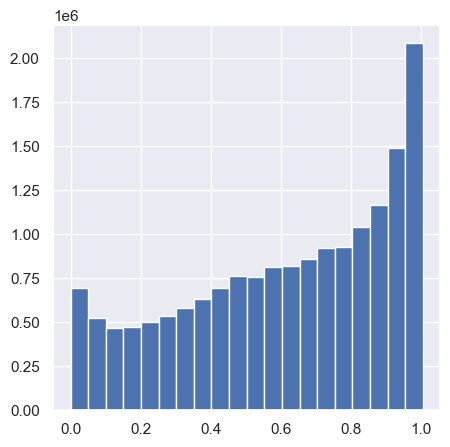

In [113]:
df_merge['percentage_docks_available'].hist(bins=20)

In [114]:
print(df_merge['percentage_docks_available'].isna().sum())

0


<AxesSubplot:xlabel='lat', ylabel='lon'>

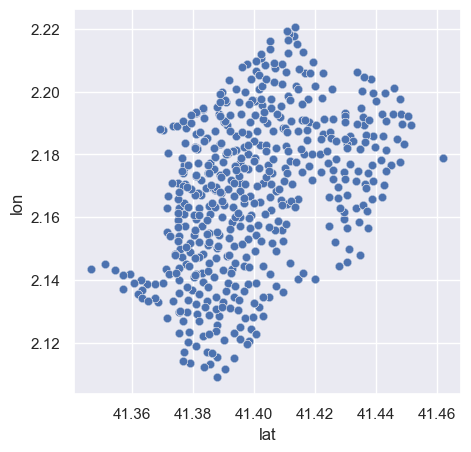

In [116]:
sns.set(rc={'figure.figsize':(5,5)})
sns.scatterplot(data=df_merge, x="lat", y="lon", alpha=0.1)

### Add Weather information

Add information relative to the wather ([source](https://www.visualcrossing.com/weather/weather-data-services#))


In [117]:
print('Start date: ', df_merge['date'].min())
print('End date: ', df_merge['date'].max())

Start date:  2019-03-28
End date:  2023-05-31


In [118]:
def weather_api_extraction(url: str) -> pd.DataFrame:
    response = requests.get(url)
    response_json = response.json()
    
    weather_df = pd.json_normalize(response_json['days'])
    
    return weather_df

In [119]:
def weather_df_drop_columns(
    weather_df: pd.DataFrame, 
    columns_to_drop: typing.List[str] = [
        'datetimeEpoch', 
        'tzoffset', 
        'source',
        'name',                     # all barcelona
        'stations',                 # which stations tracked that weather
        'severerisk'                # all nulls
        'precipprob',               # 100 if it rains, 0 otherwise. Doesn't add new info
        'preciptype',               # 'rain' if it rains, 'snow' if it snows. Doesn't add new info
        'sunrise', 'sunset',        # simplify variables, too specific
        'description',              # simplify variables, too specific
        'sunrise',                  # simplify variables, too specific
        'sunset',                   # simplify variables, too specific
        'moonphase',                # simplify variables, too specific
        'sealevelpressure',         # simplify variables, too specific
    ]
):
    
    return weather_df.drop(columns_to_drop, axis=1, errors='ignore')

In [120]:
def process_weather_df(weather_df: pd.DataFrame) -> pd.DataFrame:
    weather_df.datetime = pd.to_datetime(weather_df.datetime)
    weather_df['date'] = weather_df.datetime.dt.date
    
    return weather_df

In [121]:
os.makedirs('./weather', exist_ok=True)

if not len(os.listdir('./weather')):
    weather_url1 = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/barcelona/2019-03-28/2021-11-30?unitGroup=metric&include=days&key=4T9KXABWNUV92K2WTZMA7JXZ3&contentType=json'
    weather_df1 = weather_api_extraction(weather_url1)
    weather_df1.to_csv('./weather/weather_2019_03_28_to_2021_11_30.csv', index=False, header=True)
    
    weather_url2 = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/barcelona/2021-12-01/2023-04-30?unitGroup=metric&include=days&key=6NT6N8CRPMNTAEE2FH2EQZ98U&contentType=json'
    weather_df2 = weather_api_extraction(weather_url2)
    weather_df2.to_csv('./weather/weather_2021_12_01_to_2023_04_30.csv', index=False, header=True)

else:
    weather_df1 = pd.read_csv('./weather/weather_2019_03_28_to_2021_11_30.csv')
    weather_df2 = pd.read_csv('./weather/weather_2021_12_01_to_2023_04_30.csv')   

In [122]:
weather_df = pd\
    .concat([weather_df1, weather_df2], axis=0)\
    .reset_index(drop=True)

In [123]:
weather_df = weather_df_drop_columns(weather_df)
weather_df = process_weather_df(weather_df)

In [124]:
weather_df.head()

datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
0 2019-03-28     16.8      6.4  12.1          16.8           3.7       11.5   
1 2019-03-29     16.3      8.8  12.8          16.3           6.7       12.6   
2 2019-03-30     16.0      6.4  12.0          16.0           4.2       11.6   
3 2019-03-31     15.9      8.4  12.5          15.9           6.9       12.4   
4 2019-04-01     17.3      9.8  13.8          17.3           9.0       13.7   

   dew  humidity  precip  precipprob  precipcover  snow  snowdepth  windgust  \
0  4.4      60.6     0.0         0.0          0.0   0.0        0.0      21.5   
1  5.1      60.6     0.0         0.0          0.0   0.0        0.0      24.8   
2  5.8      66.0     0.0         0.0          0.0   0.0        0.0      24.3   
3  7.9      73.5     0.0         0.0          0.0   0.0        0.0      37.6   
4  6.1      60.7     0.0         0.0          0.0   0.0        0.0      23.4   

   windspeed  winddir  pressure  cloudcover  visibility  solarradiation  \
0       17.3     42.8    1027.6         1.1        16.1           221.4   
1       19.8     76.9    1027.2         8.9        16.1           222.3   
2       19.1     79.9    1023.8        29.4        15.5           224.5   
3       31.2     71.2    1017.5        50.3        14.7           154.2   
4       18.1    126.5    1015.2        35.0        15.3           214.7   

   solarenergy  uvindex  sunriseEpoch  sunsetEpoch        conditions  \
0         19.2      7.0    1553751710   1553796707             Clear   
1         19.1      7.0    1553838009   1553883172             Clear   
2         19.6      7.0    1553924308   1553969637  Partially cloudy   
3         12.8      6.0    1554010607   1554056102  Partially cloudy   
4         18.6      7.0    1554096907   1554142567  Partially cloudy   

                icon  severerisk        date  
0          clear-day         NaN  2019-03-28  
1          clear-day         NaN  2019-03-29  
2  partly-cloudy-day         NaN  2019-03-30  
3  partly-cloudy-day         NaN  2019-03-31  
4  partly-cloudy-day         NaN  2019-04-01

In [125]:
print(df_merge.shape)
print(weather_df.shape)

(16723475, 25)
(1495, 29)


In [126]:
df_merge.head(2)

station_id  year  month  day  hour  num_bikes_available  \
0           1  2023      1    1     0            37.500000   
1           1  2023      1    1     1            39.333333   

   num_bikes_available_types.mechanical  num_bikes_available_types.ebike  \
0                             34.916667                         2.583333   
1                             36.666667                         2.666667   

   num_docks_available  last_reported  is_charging_station  status  \
0             8.416667   1.672529e+09                  1.0     1.0   
1             6.666667   1.672533e+09                  1.0     1.0   

   is_installed  is_renting  is_returning  traffic  last_updated        ttl  \
0           1.0         1.0           1.0      0.0  1.672530e+09  11.750000   
1           1.0         1.0           1.0      0.0  1.672533e+09  10.416667   

            date_time        date  percentage_docks_available        lat  \
0 2023-01-01 00:00:00  2023-01-01                    0.183303  41.397978   
1 2023-01-01 01:00:00  2023-01-01                    0.144928  41.397978   

        lon  altitude  capacity  
0  2.180107      16.0      46.0  
1  2.180107      16.0      46.0

# Merge main dataset with weather dataset. Becareful: use how='left' to maintain all the rows from the main dataset

In [127]:
df_merge.date = pd.to_datetime(df_merge.date).dt.date
weather_df.date = pd.to_datetime(weather_df.date).dt.date

df_merge_2 = pd.merge(df_merge, weather_df, left_on='date', right_on='date', how='left')

In [128]:
values_not_in_df1 = df_merge.loc[~df_merge['date'].isin(weather_df['date']), 'date']

if not values_not_in_df1.empty:
    print(f"The following values are in main df but not in weather_df: {values_not_in_df1.value_counts()}")
else:
    print("All values in main df are also in weather df.")
    

The following values are in main df but not in weather_df: 2023-05-24    12151
2023-05-22    12146
2023-05-25    12146
2023-05-08    12144
2023-05-09    12144
2023-05-10    12144
2023-05-11    12144
2023-05-04    12143
2023-05-23    12141
2023-05-30    12138
2023-05-31    12137
2023-05-03    12126
2023-05-12    12124
2023-05-01    12120
2023-05-16    12117
2023-05-02    12117
2023-05-17    12113
2023-05-15    12112
2023-05-18    12101
2023-05-21    12095
2023-05-20    12094
2023-05-13    12085
2023-05-07    12084
2023-05-06    12074
2023-05-14    12068
2023-05-19    12061
2023-05-26    11115
2023-05-29    10117
2023-05-05     9095
2023-05-28     7075
2023-05-27     2516
Name: date, dtype: int64


In [129]:
#We are including by error the month of May of 2023. Drop it!
#Drop the rows of the df_merge_2 that contain 2023 as year and 5 as month
print(df_merge_2.shape)
df_merge_2 = df_merge_2.drop(df_merge_2[(df_merge_2['year'] == 2023) & (df_merge_2['month'] == 5)].index)
print(df_merge_2.shape)

(16723475, 53)
(16368488, 53)


In [40]:
#Do not run this cell. Capacity and the total number of bikes plus docks is not the same.
#We have to consider using only one.

#Check if the capacity column in the station information matches to the summation of number of bikes plus number of docks in the main dataset
df_merge_2['capacity_2'] = df_merge_2['num_bikes_available'] + df_merge_2['num_docks_available']

# Check if 'a' and 'b' have the same value in each row
df_merge_2['same_value'] = df_merge_2['capacity'] == df_merge_2['capacity_2']

# Count the number of rows where 'same_value' is False
count_false = (~df_merge_2['same_value']).sum()

print(count_false)

#This line i  making the kernel to crash
#df_merge_2.plot(kind='scatter', x='capacity', y='capacity_2', color='red', alpha=0.1)

df_merge_2 = df_merge_2.drop(['capacity_2'], axis=1)

11573338


### Add Covid Information

The daily covid cases that there were in Barcelona ([source](https://www.amb.cat/en/web/area-metropolitana/dades-obertes/cataleg/detall/-/dataset/covid-19-positive-cases/9147624/11692))

In [130]:
def get_covid_json(
    url: str = "https://opendata-ajuntament.barcelona.cat/data/api/action/datastore_search_sql?sql=SELECT%20*%20from%20%22f627ac0a-d05f-416d-9773-eeb464a3fc44%22%20WHERE%20%22Nom_Indicador%22%20LIKE%20%27Casos%20de%20COVID-19%20a%20Barcelona%20(diari)%27"
):
    
    res_covid = requests.get(url)
    return res_covid.json()['result']['records']

In [131]:
covid_json = get_covid_json()

In [132]:
covid_df = pd.DataFrame(covid_json)
covid_df.head()

Nom_Variable                                   Font Data_Indicador  \
0               Agència de Salut Pública de Barcelona     2020-02-25   
1               Agència de Salut Pública de Barcelona     2020-02-26   
2               Agència de Salut Pública de Barcelona     2020-02-27   
3               Agència de Salut Pública de Barcelona     2020-02-28   
4               Agència de Salut Pública de Barcelona     2020-02-29   

   Territori                                         _full_text  \
0  Barcelona  '-02':11 '-19':16 '-25':12 '1':9 '2020':10 'ag...   
1  Barcelona  '-02':11 '-19':17 '-26':12 '0':9 '2020':10 'ag...   
2  Barcelona  '-02':11 '-19':17 '-27':12 '0':9 '2020':10 'ag...   
3  Barcelona  '-02':19 '-19':13 '-28':20 '0':9 '2020':18 'ag...   
4  Barcelona  '-02':19 '-19':14 '-29':20 '0':9 '2020':18 'ag...   

  Frequencia_Indicador Valor  _id                          Nom_Indicador  \
0                diari     1    1  Casos de COVID-19 a Barcelona (diari)   
1                diari     0    2  Casos de COVID-19 a Barcelona (diari)   
2                diari     0    3  Casos de COVID-19 a Barcelona (diari)   
3                diari     0    4  Casos de COVID-19 a Barcelona (diari)   
4                diari     0    5  Casos de COVID-19 a Barcelona (diari)   

   Unitat  
0  Nombre  
1  Nombre  
2  Nombre  
3  Nombre  
4  Nombre

In [133]:
covid_df.shape

(773, 10)

In [134]:
covid_df = covid_df[['Data_Indicador', 'Valor']]
covid_df.head()

Data_Indicador Valor
0     2020-02-25     1
1     2020-02-26     0
2     2020-02-27     0
3     2020-02-28     0
4     2020-02-29     0

In [135]:
covid_df['date'] = pd.to_datetime(covid_df.Data_Indicador).dt.date

In [136]:
covid_df = covid_df\
    .drop('Data_Indicador', axis=1)\
    .rename(columns={'Valor': 'covid_cases'})

In [137]:
covid_df.sample(10)

covid_cases        date
62           66  2020-04-27
91           79  2020-05-26
730         716  2022-02-24
100          46  2020-06-04
490        1495  2021-06-29
167         221  2020-08-10
267         389  2020-11-18
216         236  2020-09-28
495         741  2021-07-04
466          65  2021-06-05

In [138]:
print(df_merge_2.shape)

df_merge_3 = pd.merge(
    df_merge_2, 
    covid_df, 
    how='left', 
    left_on='date', 
    right_on='date'
)

df_merge_3.shape

(16368488, 53)


(16368488, 54)

We only have NaN values afterwards (not previous to the start of Covid).

For those NaN, we will replace them by a percentile that is at the bottom (still not 0, as there are cases).

In [139]:
df_merge_3.covid_cases = df_merge_3.covid_cases.astype('float')

In [140]:
df_merge_3.covid_cases.describe()

count    8.637418e+06
mean     6.539184e+02
std      1.226670e+03
min      0.000000e+00
25%      9.000000e+01
50%      2.690000e+02
75%      5.800000e+02
max      8.656000e+03
Name: covid_cases, dtype: float64

In [141]:
df_merge_3.covid_cases.hist(bins=50)

<AxesSubplot:>

In [142]:
def fill_with_percentile(
    df: pd.DataFrame, 
    column: str, 
    percentile: float = 0.03,
    logging: bool = True
):
    
    quantile_value = df[column].quantile(percentile)
    
    if logging:
        print(f'Percentile {percentile} value is: ', quantile_value)
        
    df[column] = df[column].fillna(quantile_value)
    
    return df

In [143]:
df_merge_3 = fill_with_percentile(df_merge_3, 'covid_cases')

Percentile 0.03 value is:  6.0


We could add also information about in which dates the people where closed into their homes.

In [144]:
confinment_start = '2020-03-14'
confinment_date_start = datetime.strptime(confinment_start, '%Y-%m-%d').date()

In [145]:
confinment_end = '2020-06-21'
confinment_date_end = datetime.strptime(confinment_start, '%Y-%m-%d').date()

In [146]:
index_non_confinment = df_merge_3[
    (df_merge_3['date'] < confinment_date_start) |
    (df_merge_3['date'] > confinment_date_end)
].index

In [147]:
df_merge_3.loc[index_non_confinment, 'confinment'] = 0
df_merge_3['confinment'] = df_merge_3['confinment'].fillna(1)
df_merge_3['confinment'] = df_merge_3['confinment'].astype('int')

### Barcelona Events

In [ ]:
os.makedirs('./events', exist_ok=True)

In [ ]:
def get_opendataevents_json(url: str = 'https://www.bcn.cat/tercerlloc/files/opendatabcn_agenda.json'):
    res = requests.get(url)
    return res.json()

In [ ]:
if not os.path.isfile('./events/opendatabcn_agenda.json'):
    events_json = get_opendataevents_json()
    events_df = pd.DataFrame(events_json)
    events_df.to_csv('./events/opendatabcn_agenda.json', index=False, header=True)

else:
    events_df = pd.read_csv('./events/opendatabcn_agenda.json')

In [ ]:
events_df.head()

In [ ]:
# Only having active dates
events_df = events_df[events_df.core_type_name != 'Equipament']
events_df = events_df[events_df.event_status == 'ok']

In [ ]:
#def events_df_drop_columns(
#    events_df: pd.DataFrame, 
#    columns_to_drop: typing.List[str] = [
#        'register_id', 'prefix', 'suffix', 'name', 'created', 'modified', 'status', 'status_name',     # too specific
#        'core_type', 'core_type_name',                                                                 # most is only one type of value
#        'body', 'tickets_data', 'addresses', 'entity_types_data', 'attribute_categories', 'values',
#        'from_relationships', 'to_relationships', 'classifications_data', 'secondary_filters_data',
#        'timetable', 'image_data', 'gallery_data', 'warnings',                                         # unuseful information
#        'is_section_of_data', 'sections_data', 'estimated_dates', 'languages_data', 'type', 'type_name',
#        'period', 'period_name', 'event_status_name', 'event_status', 'ical',
#        'geo_epgs_25831', 'geo_epgs_23031'                                                             # unwanted loations
#    ]
#):
    
#    return events_df.drop(columns_to_drop, axis=1, errors='ignore')

In [ ]:
# Drop columns not wanted
#events_df = events_df_drop_columns(events_df)

In [ ]:
events_df = events_df.drop(['suffix', 'status', 'status_name', 'values', 'from_relationships', 'to_relationships'], axis=1)
#events_df = events_df.drop(df[df['core_type_name'] == 'Equipament'].index)
events_df = events_df.drop(['core_type', 'core_type_name', 
              'body', 'entity_types_data', 
              'attribute_categories', 'classifications_data', 
             'secondary_filters_data', 'timetable', 
             'image_data', 'warnings', 'is_section_of_data', 'sections_data',
             'type_name', 'period', 'gallery_data', 'addresses'], axis=1)
#events_df = events_df.drop(df[df['event_status'] == 'suspended'].index)
#events_df = events_df.drop(df[df['event_status'] == 'deferred'].index)
events_df = events_df.drop(['event_status_name', 'event_status', 'ical', 'estimated_dates'], axis=1)
events_df = events_df.drop(['geo_epgs_25831', 'geo_epgs_23031'], axis=1)


In [ ]:
events_df = events_df.drop(['created', 'modified'], axis=1)
events_df = events_df.drop(events_df[events_df['type'] == 'permanent'].index)
#I am dropping the permanent events because they do not have significant
#impact of the bicing frequency

In [ ]:
# Drop events with not enough data
events_df.dropna(
    axis=0, 
    how='any', 
    subset=['geo_epgs_4326', 'start_date'], 
    inplace=True
)

In [ ]:
events_df.head()

In [ ]:
def get_event_geographics(geo_position: str):
    geo_position = ast.literal_eval(geo_position)
    return geo_position['x'], geo_position['y']

In [ ]:
events_geographic_x_y = events_df.geo_epgs_4326.apply(lambda x: get_event_geographics(x))
events_df['x'] = [x for x, _ in events_geographic_x_y]
events_df['y'] = [y for _, y in events_geographic_x_y]

events_df = events_df[events_df.x > 0]
events_df = events_df[events_df.y > 0]

events_df.drop(['geo_epgs_4326'], axis=1, inplace=True)

In [ ]:
sns.jointplot(x="x", y="y", data= events_df, alpha=0.1)

In [ ]:
# In the case of null values of end date, we will assume is the same as start date (we will consider only days)
events_df.end_date.fillna(events_df.start_date, inplace=True)

In [ ]:
events_df['start_date'] = pd.to_datetime(events_df['start_date'], utc=True).dt.date
events_df['end_date'] = pd.to_datetime(events_df['end_date'], utc=True).dt.date

events_df['year'] = pd.to_datetime(events_df['start_date'], utc=True).dt.year
print(events_df['year'].value_counts())

### Include the dataframe with the holidays

In [148]:
from functools import lru_cache
import ics
import icalendar
from icalendar import Calendar, Event, vCalAddress, vText
from pathlib import Path
import pytz

In [149]:
e = open('calendarifestius_en.ics', 'rb')
ecal = icalendar.Calendar.from_ical(e.read())
for component in ecal.walk():
    print(component.name)
e.close()

VCALENDAR
VTIMEZONE
DAYLIGHT
STANDARD
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT


In [150]:
# Extract relevant information
events = []
for event in ecal.walk('VEVENT'):
    event_data = {
        'Summary': event.get('summary'),
        'Start': event.get('dtstart').dt,
        'End': event.get('dtend').dt,
        # Add more properties as needed
    }
    events.append(event_data)

# Create a DataFrame from the extracted information
df_ecal = pd.DataFrame(events)

# Print the DataFrame
print(df_ecal.dtypes)

Summary    object
Start      object
End        object
dtype: object


In [151]:
df_ecal['Start'] = pd.to_datetime(df_ecal['Start'], utc=True)
df_ecal['End'] = pd.to_datetime(df_ecal['End'], utc=True)
print(df_ecal.dtypes)

Summary                 object
Start      datetime64[ns, UTC]
End        datetime64[ns, UTC]
dtype: object


In [152]:
df_ecal = df_ecal.rename(columns={"Start": 'start_date', "End": 'end_date', "Summary":"name"})


In [153]:
df_ecal['year'] = df_ecal['start_date'].dt.year
df_ecal['month'] = df_ecal['start_date'].dt.month
df_ecal['day'] = df_ecal['start_date'].dt.day

df_ecal['end_day'] = df_ecal['end_date'].dt.day
df_ecal['end_month'] = df_ecal['end_date'].dt.month

In [154]:
#Since these holidays last the whole week, I will remove them and add
#manually christmas and easter holidays
df_ecal = df_ecal.drop(df_ecal[df_ecal['name'] == 'Good Friday'].index)
df_ecal = df_ecal.drop(df_ecal[df_ecal['name'] == 'Easter Monday'].index)
df_ecal = df_ecal.drop(df_ecal[df_ecal['name'] == 'Christmas'].index)
df_ecal = df_ecal.drop(df_ecal[df_ecal['name'] == 'Boxing Day'].index)

In [155]:
def holy_week(df, name, start_date, end_date):
    df = pd.DataFrame({'name': [name], 'start_date': [start_date],
                              'end_date' : [end_date]})
    df['start_date'] = pd.to_datetime(df['start_date'], utc=True)
    df['end_date'] = pd.to_datetime(df['end_date'], utc=True)
    df['day'] = df['start_date'].dt.day
    df['month'] = df['start_date'].dt.month
    df['year'] = df['start_date'].dt.year
    df['end_day'] = df['end_date'].dt.day
    df['end_month'] = df['end_date'].dt.month
    return df
   
holy_week_2023 = holy_week(df, 'Holy Week 2023', "2023-04-02 00:00:00+00:00", "2023-04-10 00:00:00+00:00")
holy_week_2022 = holy_week(df, 'Holy Week 2022', "2022-04-10 00:00:00+00:00", "2022-04-18 00:00:00+00:00")
holy_week_2021 = holy_week(df, 'Holy Week 2021', "2021-03-28 00:00:00+00:00", "2021-04-05 00:00:00+00:00")
holy_week_2020 = holy_week(df, 'Holy Week 2020', "2020-04-05 00:00:00+00:00", "2020-04-13 00:00:00+00:00")
holy_week_2019 = holy_week(df, 'Holy Week 2019', "2019-04-14 00:00:00+00:00", "2019-04-22 00:00:00+00:00")


df_ecal = df_ecal.append(holy_week_2023, ignore_index=True)
df_ecal = df_ecal.append(holy_week_2022, ignore_index=True)
df_ecal = df_ecal.append(holy_week_2021, ignore_index=True)
df_ecal = df_ecal.append(holy_week_2020, ignore_index=True)
df_ecal = df_ecal.append(holy_week_2019, ignore_index=True)
df_ecal.head()

name                start_date  \
0     Epiphany / Three Kings’ Day 2023-01-06 00:00:00+00:00   
1                      Labour Day 2023-05-01 00:00:00+00:00   
2     Local holidays in Barcelona 2023-06-05 00:00:00+00:00   
3  Sant Joan / Midsummer solstice 2023-06-24 00:00:00+00:00   
4              Assumption of Mary 2023-08-15 00:00:00+00:00   

                   end_date  year  month  day  end_day  end_month  
0 2023-01-07 00:00:00+00:00  2023      1    6        7          1  
1 2023-05-02 00:00:00+00:00  2023      5    1        2          5  
2 2023-06-06 00:00:00+00:00  2023      6    5        6          6  
3 2023-06-25 00:00:00+00:00  2023      6   24       25          6  
4 2023-08-16 00:00:00+00:00  2023      8   15       16          8

In [156]:
def xmas_time(df, name, start_date, end_date):
    df = pd.DataFrame({'name': [name], 'start_date': [start_date],
                              'end_date' : [end_date]})
    df['start_date'] = pd.to_datetime(df['start_date'], utc=True)
    df['end_date'] = pd.to_datetime(df['end_date'], utc=True)
    df['day'] = df['start_date'].dt.day
    df['month'] = df['start_date'].dt.month
    df['year'] = df['start_date'].dt.year
    df['end_day'] = df['end_date'].dt.day
    df['end_month'] = df['end_date'].dt.month
    return df
   
xmas_2023 = xmas_time(df, 'Christmas 2023', "2023-12-25 00:00:00+00:00", "2024-01-02 00:00:00+00:00")
xmas_2022 = xmas_time(df, 'Christmas 2022', "2022-12-25 00:00:00+00:00", "2023-01-02 00:00:00+00:00")
xmas_2021 = xmas_time(df, 'Christmas 2021', "2021-12-25 00:00:00+00:00", "2022-01-02 00:00:00+00:00")
xmas_2020 = xmas_time(df, 'Christmas 2020', "2020-12-25 00:00:00+00:00", "2021-01-02 00:00:00+00:00")
xmas_2019 = xmas_time(df, 'Christmas 2019', "2019-12-25 00:00:00+00:00", "2020-01-02 00:00:00+00:00")


df_ecal = df_ecal.append(xmas_2023, ignore_index=True)
df_ecal = df_ecal.append(xmas_2022, ignore_index=True)
df_ecal = df_ecal.append(xmas_2021, ignore_index=True)
df_ecal = df_ecal.append(xmas_2020, ignore_index=True)
df_ecal = df_ecal.append(xmas_2019, ignore_index=True)
df_ecal.head()

name                start_date  \
0     Epiphany / Three Kings’ Day 2023-01-06 00:00:00+00:00   
1                      Labour Day 2023-05-01 00:00:00+00:00   
2     Local holidays in Barcelona 2023-06-05 00:00:00+00:00   
3  Sant Joan / Midsummer solstice 2023-06-24 00:00:00+00:00   
4              Assumption of Mary 2023-08-15 00:00:00+00:00   

                   end_date  year  month  day  end_day  end_month  
0 2023-01-07 00:00:00+00:00  2023      1    6        7          1  
1 2023-05-02 00:00:00+00:00  2023      5    1        2          5  
2 2023-06-06 00:00:00+00:00  2023      6    5        6          6  
3 2023-06-25 00:00:00+00:00  2023      6   24       25          6  
4 2023-08-16 00:00:00+00:00  2023      8   15       16          8

In [157]:
print(df_ecal.shape)

# Define a function to duplicate rows based on the days between 'starting_date' and 'ending_date'
def duplicate_rows(row):
    date_range = pd.date_range(start=row['start_date'], end=row['end_date'], closed='left')
    duplicated_rows = pd.DataFrame({'start_date': date_range[1:]}, index=range(1, len(date_range)))
    return duplicated_rows

# Apply the function to each row and concatenate the results
duplicated_df = pd.concat(df_ecal.apply(duplicate_rows, axis=1).tolist())
duplicated_df['day'] = duplicated_df['start_date'].dt.day
duplicated_df['month'] = duplicated_df['start_date'].dt.month
duplicated_df['year'] = duplicated_df['start_date'].dt.year
# Merge duplicated rows with the original DataFrame
df_ecal = pd.concat([df_ecal, duplicated_df], ignore_index=True)

print(df_ecal.shape)

(21, 8)
(91, 8)


In [158]:
# Define the condition
condition = (df_ecal['year'] == 2023) & (df_ecal['month'] == 4)
# Modify the values of column 'c' where the condition is True
df_ecal.loc[condition, 'name'] = 'Holy week 2023'

# Define the condition
condition_22 = (df_ecal['year'] == 2022) & (df_ecal['month'] == 4)
# Modify the values of column 'c' where the condition is True
df_ecal.loc[condition_22, 'name'] = 'Holy week 2022'

# Define the condition
condition_21 = (df_ecal['year'] == 2021) & (df_ecal['month'] == 4)
# Modify the values of column 'c' where the condition is True
df_ecal.loc[condition_21, 'name'] = 'Holy week 2021'

# Define the condition
condition_21 = (df_ecal['year'] == 2021) & (df_ecal['month'] == 3)
# Modify the values of column 'c' where the condition is True
df_ecal.loc[condition_21, 'name'] = 'Holy week 2021'

# Define the condition
condition_20 = (df_ecal['year'] == 2020) & (df_ecal['month'] == 4)
# Modify the values of column 'c' where the condition is True
df_ecal.loc[condition_20, 'name'] = 'Holy week 2020'

# Define the condition
condition_19 = (df_ecal['year'] == 2019) & (df_ecal['month'] == 4)
# Modify the values of column 'c' where the condition is True
df_ecal.loc[condition_19, 'name'] = 'Holy week 2019'

print(df_ecal.shape)

(91, 8)


In [159]:
df_ecal = df_ecal.sort_index(axis=0)
df_ecal

name                start_date  \
0      Epiphany / Three Kings’ Day 2023-01-06 00:00:00+00:00   
1                       Labour Day 2023-05-01 00:00:00+00:00   
2      Local holidays in Barcelona 2023-06-05 00:00:00+00:00   
3   Sant Joan / Midsummer solstice 2023-06-24 00:00:00+00:00   
4               Assumption of Mary 2023-08-15 00:00:00+00:00   
..                             ...                       ...   
86                             NaN 2019-12-28 00:00:00+00:00   
87                             NaN 2019-12-29 00:00:00+00:00   
88                             NaN 2019-12-30 00:00:00+00:00   
89                             NaN 2019-12-31 00:00:00+00:00   
90                             NaN 2020-01-01 00:00:00+00:00   

                    end_date  year  month  day  end_day  end_month  
0  2023-01-07 00:00:00+00:00  2023      1    6      7.0        1.0  
1  2023-05-02 00:00:00+00:00  2023      5    1      2.0        5.0  
2  2023-06-06 00:00:00+00:00  2023      6    5      6.0        6.0  
3  2023-06-25 00:00:00+00:00  2023      6   24     25.0        6.0  
4  2023-08-16 00:00:00+00:00  2023      8   15     16.0        8.0  
..                       ...   ...    ...  ...      ...        ...  
86                       NaT  2019     12   28      NaN        NaN  
87                       NaT  2019     12   29      NaN        NaN  
88                       NaT  2019     12   30      NaN        NaN  
89                       NaT  2019     12   31      NaN        NaN  
90                       NaT  2020      1    1      NaN        NaN  

[91 rows x 8 columns]

In [160]:
# XMAS 2023-2024
condition = (df_ecal['year'] == 2023) & (df_ecal['month'] == 12)
df_ecal.loc[condition, 'name'] = 'Christmas 2023'

condition = (df_ecal['year'] == 2024) & (df_ecal['month'] == 1)
df_ecal.loc[condition, 'name'] = 'Christmas 2023'

# XMAS 2022-2023
condition_22 = (df_ecal['year'] == 2022) & (df_ecal['month'] == 12)
df_ecal.loc[condition_22, 'name'] = 'Christmas 2022'

condition_22 = (df_ecal['year'] == 2023) & (df_ecal['month'] == 1)
df_ecal.loc[condition_22, 'name'] = 'Christmas 2022'

# XMAS 2021-2022
condition_21 = (df_ecal['year'] == 2021) & (df_ecal['month'] == 12)
df_ecal.loc[condition_21, 'name'] = 'Christmas 2021'

condition_21 = (df_ecal['year'] == 2022) & (df_ecal['month'] == 1)
df_ecal.loc[condition_21, 'name'] = 'Christmas 2021'

# XMAS 2020-2021
condition_20 = (df_ecal['year'] == 2020) & (df_ecal['month'] == 12)
df_ecal.loc[condition_20, 'name'] = 'Christmas 2020'

condition_20 = (df_ecal['year'] == 2021) & (df_ecal['month'] == 1)
df_ecal.loc[condition_20, 'name'] = 'Christmas 2020'

# XMAS 2019-2020
condition_19 = (df_ecal['year'] == 2019) & (df_ecal['month'] == 12)
df_ecal.loc[condition_19, 'name'] = 'Christmas 2019'

condition_19 = (df_ecal['year'] == 2020) & (df_ecal['month'] == 1)
df_ecal.loc[condition_19, 'name'] = 'Christmas 2019'

In [161]:
df_ecal

name                start_date  \
0                   Christmas 2022 2023-01-06 00:00:00+00:00   
1                       Labour Day 2023-05-01 00:00:00+00:00   
2      Local holidays in Barcelona 2023-06-05 00:00:00+00:00   
3   Sant Joan / Midsummer solstice 2023-06-24 00:00:00+00:00   
4               Assumption of Mary 2023-08-15 00:00:00+00:00   
..                             ...                       ...   
86                  Christmas 2019 2019-12-28 00:00:00+00:00   
87                  Christmas 2019 2019-12-29 00:00:00+00:00   
88                  Christmas 2019 2019-12-30 00:00:00+00:00   
89                  Christmas 2019 2019-12-31 00:00:00+00:00   
90                  Christmas 2019 2020-01-01 00:00:00+00:00   

                    end_date  year  month  day  end_day  end_month  
0  2023-01-07 00:00:00+00:00  2023      1    6      7.0        1.0  
1  2023-05-02 00:00:00+00:00  2023      5    1      2.0        5.0  
2  2023-06-06 00:00:00+00:00  2023      6    5      6.0        6.0  
3  2023-06-25 00:00:00+00:00  2023      6   24     25.0        6.0  
4  2023-08-16 00:00:00+00:00  2023      8   15     16.0        8.0  
..                       ...   ...    ...  ...      ...        ...  
86                       NaT  2019     12   28      NaN        NaN  
87                       NaT  2019     12   29      NaN        NaN  
88                       NaT  2019     12   30      NaN        NaN  
89                       NaT  2019     12   31      NaN        NaN  
90                       NaT  2020      1    1      NaN        NaN  

[91 rows x 8 columns]

In [162]:
# Define the condition to drop rows prior to a specific datetime
condition_1 = df_ecal['start_date'] < pd.to_datetime('2019-03-28 00:00:00+00:00', utc=True)
print(df_ecal.shape)
condition_2 = df_ecal['start_date'] > pd.to_datetime('2023-04-30 00:00:00+00:00', utc=True)
# Drop the rows that satisfy the condition
df_ecal = df_ecal.drop(df_ecal[condition_1].index)
df_ecal = df_ecal.drop(df_ecal[condition_2].index)
print(df_ecal.shape)

(91, 8)
(73, 8)


In [163]:
df_ecal = df_ecal.drop(['end_date', 'end_day', 'end_month'], axis=1)

## Append df events_df together with the df_ecal, although it is probably unneccessary.

In [ ]:
df_append = events_df.append(df_ecal, ignore_index=True)

In [ ]:
#For the moment I am going to drop the tickets and the language,
#unless we found a way to be related
df_append = df_append.drop(['tickets_data', 'languages_data'], axis=1)

In [ ]:
df_append['period_name'] = df_append['period_name'].fillna(0)
df_append['period_name'] = np.where(df_append['period_name'] == 0, 'anual', df_append['period_name'])

df_append['type'] = df_append['type'].fillna(0)
df_append['type'] = np.where(df_append['type'] == 0, 'repetitive', df_append['type'])

df_append['prefix'] = df_append['prefix'].fillna(0)
df_append['prefix'] = np.where(df_append['prefix'] == 0, 'Local holiday', df_append['prefix'])


In [ ]:
# Define the condition
condition_holy_week = df_append['name'].str.startswith('Holy') == True

# Modify the values of column 'c' where the condition is True
df_append.loc[condition_holy_week, 'type'] = 'unique'

In [ ]:
# Define the condition
condition_xmas = df_append['name'].str.startswith('Christmas') == True

# Modify the values of column 'c' where the condition is True
df_append.loc[condition_xmas, 'type'] = 'unique'

In [ ]:
# Define the condition to drop rows prior to a specific datetime
condition_1 = df_append['start_date'] < pd.to_datetime('2019-03-28 00:00:00+00:00', utc=True)
print(df_append.shape)
condition_2 = df_append['start_date'] > pd.to_datetime('2023-04-30 00:00:00+00:00', utc=True)
# Drop the rows that satisfy the condition
df_append = df_append.drop(df_append[condition_1].index)
df_append = df_append.drop(df_append[condition_2].index)
print(df_append.shape)

In [ ]:
# Filter out by maximum and minimum dates of df
#df_min_date, df_max_date = df.date.min(), df.date.max()

#events_df = events_df[events_df.start_date > df_min_date]
#events_df = events_df[events_df.end_date < df_max_date]

In [ ]:
print(df_append.shape)
df_append.head()

## These are the data sets that we have:
events_df --> the events happening in Barcelona, with specific location
df_ecal --> calendar with the local holidays in Barcelona
df_append --> append of the two previous dataframes. I don't think we need it

In [ ]:
std_dev_x, std_dev_y = events_df.x.std(), events_df.y.std()

In [ ]:
# Filter df by the dates that we have
df_common_events = pd.concat(
    [
        pd.merge(df, events_df, left_on='date', right_on='start_date'), 
        pd.merge(df, events_df, left_on='date', right_on='end_date')
    ],
    axis=0
).drop_duplicates()

In [ ]:
print(df_common_events.shape)

print(df_common_events['year_x'].value_counts())

In [ ]:
with tqdm(total=len(events_df)) as pbar:
    for idx, row in events_df.iterrows():    
        # Filter by the range of the dates
        x, y = row.x, row.y
        start_date, end_date = row['start_date'], row['end_date']
        range_dates = pd.date_range(start_date, end_date)
        range_df = df_common_events[df_common_events.date.isin(range_dates)]
        
        if len(range_df) > 0:
            # Near position of the event with relation of the biking center (30% of standard deviations of x & y)
            range_df = range_df[(range_df.lat > x - std_dev_x * 0.3) & (range_df.lat < x + std_dev_x * 0.3)]
            range_df = range_df[(range_df.lat > y - std_dev_y * 0.3) & (range_df.lat < y + std_dev_y * 0.3)]
            df.loc[range_df.index, 'has_event'] = 1

        pbar.update(1)
    

In [ ]:
df.has_event = df.has_event.fillna(0)

In [ ]:
df.head()

In [ ]:
df['year'].value_counts()

In [ ]:
df.columns.values

# Come back to df_ecal data set. Lastest modifications before merging to the main data set

In [164]:
df_ecal = df_ecal.rename(columns={"start_date": 'date_time'})
df_ecal['has_holidays'] = df_ecal['name']
df_ecal['has_holidays'] = 1

df_ecal['date'] = pd.to_datetime(df_ecal['date_time']).dt.date
df_ecal.head()

name                 date_time  year  month  day  has_holidays  \
0   Christmas 2022 2023-01-06 00:00:00+00:00  2023      1    6             1   
11  Holy week 2023 2023-04-02 00:00:00+00:00  2023      4    2             1   
12  Holy week 2022 2022-04-10 00:00:00+00:00  2022      4   10             1   
13  Holy week 2021 2021-03-28 00:00:00+00:00  2021      3   28             1   
14  Holy week 2020 2020-04-05 00:00:00+00:00  2020      4    5             1   

          date  
0   2023-01-06  
11  2023-04-02  
12  2022-04-10  
13  2021-03-28  
14  2020-04-05

In [165]:
#We only need the column has_holidays and the column 'date'. Drop the rest:
df_ecal = df_ecal.drop(['name', 'date_time', 'year', 'month', 'day'], axis=1)

In [166]:
df_ecal

has_holidays        date
0              1  2023-01-06
11             1  2023-04-02
12             1  2022-04-10
13             1  2021-03-28
14             1  2020-04-05
..           ...         ...
86             1  2019-12-28
87             1  2019-12-29
88             1  2019-12-30
89             1  2019-12-31
90             1  2020-01-01

[73 rows x 2 columns]

In [167]:
df_ecal.date = pd.to_datetime(df_ecal.date).dt.date

Merge main dataset with df_ecal 

In [168]:
print(df_merge_3.shape)
df_merge_4 = pd.merge(df_merge_3, df_ecal, on=['date'], how='left')
print(df_merge_4.shape)
print(df_merge_4['has_holidays'].value_counts())

(16368488, 55)
(16368488, 56)
1.0    706879
Name: has_holidays, dtype: int64


In [169]:
print(df_merge_4['has_holidays'].isna().sum())
df_merge_4.has_holidays.fillna(0, inplace=True)
print(df_merge_4['has_holidays'].isna().sum())

print(df_merge_4['has_holidays'].value_counts())

15661609
0
0.0    15661609
1.0      706879
Name: has_holidays, dtype: int64


In [170]:
df_merge_4.head(3)

station_id  year  month  day  hour  num_bikes_available  \
0           1  2023      1    1     0            37.500000   
1           1  2023      1    1     1            39.333333   
2           1  2023      1    1     2            38.666667   

   num_bikes_available_types.mechanical  num_bikes_available_types.ebike  \
0                             34.916667                         2.583333   
1                             36.666667                         2.666667   
2                             37.416667                         1.250000   

   num_docks_available  last_reported  is_charging_station  status  \
0             8.416667   1.672529e+09                  1.0     1.0   
1             6.666667   1.672533e+09                  1.0     1.0   
2             7.250000   1.672537e+09                  1.0     1.0   

   is_installed  is_renting  is_returning  traffic  last_updated        ttl  \
0           1.0         1.0           1.0      0.0  1.672530e+09  11.750000   
1           1.0         1.0           1.0      0.0  1.672533e+09  10.416667   
2           1.0         1.0           1.0      0.0  1.672537e+09  14.000000   

            date_time        date  percentage_docks_available        lat  \
0 2023-01-01 00:00:00  2023-01-01                    0.183303  41.397978   
1 2023-01-01 01:00:00  2023-01-01                    0.144928  41.397978   
2 2023-01-01 02:00:00  2023-01-01                    0.157895  41.397978   

        lon  altitude  capacity   datetime  tempmax  tempmin  temp  \
0  2.180107      16.0      46.0 2023-01-01     17.3      7.0  10.6   
1  2.180107      16.0      46.0 2023-01-01     17.3      7.0  10.6   
2  2.180107      16.0      46.0 2023-01-01     17.3      7.0  10.6   

   feelslikemax  feelslikemin  feelslike  dew  humidity  precip  precipprob  \
0          17.3           4.7        9.8  7.5      81.4     0.0         0.0   
1          17.3           4.7        9.8  7.5      81.4     0.0         0.0   
2          17.3           4.7        9.8  7.5      81.4     0.0         0.0   

   precipcover  snow  snowdepth  windgust  windspeed  winddir  pressure  \
0          0.0   0.0        0.0      14.8       12.5    330.9    1025.3   
1          0.0   0.0        0.0      14.8       12.5    330.9    1025.3   
2          0.0   0.0        0.0      14.8       12.5    330.9    1025.3   

   cloudcover  visibility  solarradiation  solarenergy  uvindex  sunriseEpoch  \
0        61.6        14.3            47.9          4.2      3.0  1.672557e+09   
1        61.6        14.3            47.9          4.2      3.0  1.672557e+09   
2        61.6        14.3            47.9          4.2      3.0  1.672557e+09   

    sunsetEpoch        conditions               icon  severerisk  covid_cases  \
0  1.672591e+09  Partially cloudy  partly-cloudy-day        10.0          6.0   
1  1.672591e+09  Partially cloudy  partly-cloudy-day        10.0          6.0   
2  1.672591e+09  Partially cloudy  partly-cloudy-day        10.0          6.0   

   confinment  has_holidays  
0           0           1.0  
1           0           1.0  
2           0           1.0

Once we have extended our dataframe with external sources, we are going to make the selection of the columns that we want.

In [171]:
selected_columns_df = [
    'station_id', 
    'num_bikes_available', 'num_bikes_available_types.mechanical',                            # docks info
    'num_bikes_available_types.ebike', 'num_docks_available', 'percentage_docks_available',   # docks info
    'status', 'lat', 'lon', 'altitude', 'capacity',                                           # station info
    'year', 'month', 'day', 'hour', 'date_time', 'date',                                      # time info
    'traffic', 'covid_cases', 'confinment', 'has_holidays',                                     # context info
    'temp', 'feelslike', 'humidity', 'precip', 'snow', 'windspeed', 'uvindex', 'visibility',  # meteorological info
]

selected_df = df_merge_4[selected_columns_df]

In [172]:
# Checkpoint of the extended df with external sources
selected_df.to_csv(
    'df_selected.csv.gz', 
    index=False, 
    header=True, 
    compression='gzip'
)

In [5]:
import gzip
selected_df = pd.read_csv('df_selected.csv.gz', compression='gzip', 
                            header=0, sep=',', quotechar='"')

In [173]:
selected_df.shape

(16368488, 29)

## Data Engineering

Engineer new variables from the information that we already have. 

In [174]:
selected_df.date_time = pd.to_datetime(selected_df.date_time)

### Time

In [175]:
# Would need to get the dummies for them
date_time_fields = ['day_info', 'hour_info', 'month_info']

Related to the **day** (weekend).

In [176]:
def get_day_info(date_time):
    return 'weekend' if date_time.weekday() in [5, 6] else 'weekday'

In [177]:
selected_df['day_info'] = selected_df.date_time.apply(lambda x: get_day_info(x))

Related to the **hour** (which time of day it was).

In [178]:
def get_hour_info(date_time):
    if date_time.hour in range(5):
        return 'late_night'

    elif date_time.hour in range(5, 9):
        return 'early_morning'

    elif date_time.hour in range(9, 13):
        return 'morning'
    
    elif date_time.hour in range(13, 17):
        return 'noon'
    
    elif date_time.hour in range(17, 21):
        return 'eve'
    
    return 'night'

In [179]:
selected_df['hour_info'] = selected_df.date_time.apply(lambda x: get_hour_info(x))

Related to the **month** (season).

In [180]:
def get_month_info(date):
    if date.month in (3, 4, 5):
        return 'spring'
    
    elif date.month in (6, 7, 8):
        return 'summer'
    
    elif date.month in (9, 10, 11):
        return 'autumn'
    
    return 'winter'

In [181]:
selected_df['month_info'] = selected_df.date_time.apply(lambda x: get_month_info(x))

In [182]:
selected_df.head(3)

station_id  num_bikes_available  num_bikes_available_types.mechanical  \
0           1            37.500000                             34.916667   
1           1            39.333333                             36.666667   
2           1            38.666667                             37.416667   

   num_bikes_available_types.ebike  num_docks_available  \
0                         2.583333             8.416667   
1                         2.666667             6.666667   
2                         1.250000             7.250000   

   percentage_docks_available  status        lat       lon  altitude  \
0                    0.183303     1.0  41.397978  2.180107      16.0   
1                    0.144928     1.0  41.397978  2.180107      16.0   
2                    0.157895     1.0  41.397978  2.180107      16.0   

   capacity  year  month  day  hour           date_time        date  traffic  \
0      46.0  2023      1    1     0 2023-01-01 00:00:00  2023-01-01      0.0   
1      46.0  2023      1    1     1 2023-01-01 01:00:00  2023-01-01      0.0   
2      46.0  2023      1    1     2 2023-01-01 02:00:00  2023-01-01      0.0   

   covid_cases  confinment  has_holidays  temp  feelslike  humidity  precip  \
0          6.0           0           1.0  10.6        9.8      81.4     0.0   
1          6.0           0           1.0  10.6        9.8      81.4     0.0   
2          6.0           0           1.0  10.6        9.8      81.4     0.0   

   snow  windspeed  uvindex  visibility day_info   hour_info month_info  
0   0.0       12.5      3.0        14.3  weekend  late_night     winter  
1   0.0       12.5      3.0        14.3  weekend  late_night     winter  
2   0.0       12.5      3.0        14.3  weekend  late_night     winter

### Data Shifting

We need to create a shift of the availability in the previous availabilities.

In [183]:
selected_df = selected_df.sort_values(['station_id', 'date_time'], ascending=True)

In [184]:
df_shifted = pd.DataFrame()

In [185]:
for station_id in tqdm(selected_df.station_id.unique()):
    station_df = selected_df[selected_df.station_id == station_id]
    station_df['ctx-4'] = station_df.percentage_docks_available.shift(4)
    station_df['ctx-3'] = station_df.percentage_docks_available.shift(3)
    station_df['ctx-2'] = station_df.percentage_docks_available.shift(2)
    station_df['ctx-1'] = station_df.percentage_docks_available.shift(1)
    
    df_shifted = pd.concat([station_df, df_shifted], axis=0)
    
# Checkpoint of the shifted_df
df_shifted.to_csv(
    'df_shifted.csv.gz', 
    index=False, 
    header=True, 
    compression='gzip'
)

100%|███████████████████████████████████████| 516/516 [1:08:34<00:00,  7.97s/it]


### Check point of the shifted dataframe

In [3]:
import gzip
df_shifted_final = pd.read_csv('df_shifted.csv.gz', compression='gzip', 
                               header=0, sep=',', quotechar='"')

print(df_shifted_final.shape)

(16368488, 36)


In [4]:
df_shifted_copy = df_shifted_final.copy()
# Find values in df2['column_name'] that are not in df1['column_name']

#values_not_in_df1 = df_shifted_copy.loc[~df_shifted_copy['station_id'].isin(selected_df['station_id']), 'station_id']

#if not values_not_in_df1.empty:
#    print(f"The following values are in main df but not in station_df: {values_not_in_df1.value_counts()}")
#else:
#    print("All values in df2 are also in df1.")
    

In [33]:
print('How many rows have NaN values after calculating the shifts?')
print(df_shifted_copy['ctx-4'].isna().sum())
print(df_shifted_copy['ctx-3'].isna().sum())
print(df_shifted_copy['ctx-2'].isna().sum())
print(df_shifted_copy['ctx-1'].isna().sum())
print(df_shifted_copy['percentage_docks_available'].isna().sum())

How many rows have NaN values after calculating the shifts?
2063
1548
1032
516
0


In [5]:
#Substitute the NaN values of the percentage of docks available by the median value
#This is not neccessary anymore
def median_values(df, column_name):
    df_column = df.loc[:, [column_name]]
    df_column = df_column.dropna()
    median = df_column.median()
    print(median)
    df[column_name].fillna(0, inplace=True)
    df[column_name] = np.where(df[column_name] == 0, 
                               median, 
                               df[column_name])
    return df


df_shifted_copy = median_values(df_shifted_copy, 'percentage_docks_available')
print(df_shifted_copy['percentage_docks_available'].isna().sum())

NameError: name 'df_shifted_copy' is not defined

In [5]:
#Fill Nan values of the shifts by the original value without the shift
df_shifted_copy['ctx-4'].fillna(df_shifted_copy['percentage_docks_available'], inplace=True)
df_shifted_copy['ctx-3'].fillna(df_shifted_copy['percentage_docks_available'], inplace=True)
df_shifted_copy['ctx-2'].fillna(df_shifted_copy['percentage_docks_available'], inplace=True)
df_shifted_copy['ctx-1'].fillna(df_shifted_copy['percentage_docks_available'], inplace=True)

print('This is how many NaN values we have in the shifts after substituting them by the percentage of docks available')
print(df_shifted_copy['ctx-4'].isna().sum())
print(df_shifted_copy['ctx-3'].isna().sum())
print(df_shifted_copy['ctx-2'].isna().sum())
print(df_shifted_copy['ctx-1'].isna().sum())

This is how many NaN values we have in the shifts after substituting them by the percentage of docks available
0
0
0
0


In [42]:
df_shifted_copy.head()

station_id  num_bikes_available  num_bikes_available_types.mechanical  \
0         532             0.666667                                   0.0   
1         532             1.000000                                   0.0   
2         532             1.000000                                   0.0   
3         532             1.000000                                   0.0   
4         532             1.000000                                   0.0   

   num_bikes_available_types.ebike  num_docks_available  \
0                         0.666667             0.333333   
1                         1.000000             0.000000   
2                         1.000000             0.000000   
3                         1.000000             0.000000   
4                         1.000000             0.000000   

   percentage_docks_available  status        lat       lon  altitude  \
0                    0.333333     1.0  41.395472  2.170939      24.0   
1                    0.000000     1.0  41.395472  2.170939      24.0   
2                    0.000000     1.0  41.395472  2.170939      24.0   
3                    0.000000     1.0  41.395472  2.170939      24.0   
4                    0.000000     1.0  41.395472  2.170939      24.0   

   capacity  year  month  day  hour            date_time        date  traffic  \
0       1.0  2022     11   11    10  2022-11-11 10:00:00  2022-11-11      0.0   
1       1.0  2022     11   11    11  2022-11-11 11:00:00  2022-11-11      0.0   
2       1.0  2022     11   11    12  2022-11-11 12:00:00  2022-11-11      0.0   
3       1.0  2022     11   11    13  2022-11-11 13:00:00  2022-11-11      0.0   
4       1.0  2022     11   11    14  2022-11-11 14:00:00  2022-11-11      0.0   

   covid_cases  confinment  has_holidays  temp  feelslike  humidity  precip  \
0          6.0           0           0.0  17.2       17.2      77.7     0.0   
1          6.0           0           0.0  17.2       17.2      77.7     0.0   
2          6.0           0           0.0  17.2       17.2      77.7     0.0   
3          6.0           0           0.0  17.2       17.2      77.7     0.0   
4          6.0           0           0.0  17.2       17.2      77.7     0.0   

   snow  windspeed  uvindex  visibility day_info hour_info month_info  \
0   0.0       26.6      4.0        15.5  weekday   morning     autumn   
1   0.0       26.6      4.0        15.5  weekday   morning     autumn   
2   0.0       26.6      4.0        15.5  weekday   morning     autumn   
3   0.0       26.6      4.0        15.5  weekday      noon     autumn   
4   0.0       26.6      4.0        15.5  weekday      noon     autumn   

      ctx-4     ctx-3     ctx-2     ctx-1  
0  0.333333  0.333333  0.333333  0.333333  
1  0.000000  0.000000  0.000000  0.333333  
2  0.000000  0.000000  0.333333  0.000000  
3  0.000000  0.333333  0.000000  0.000000  
4  0.333333  0.000000  0.000000  0.000000

In [46]:
ax = df_shifted_copy['percentage_docks_available'].hist(bins=50, color='blue', alpha=0.5, figsize=(10,3), legend=True)
ax = df_shifted_copy['ctx-1'].hist(bins=50, color='red', alpha=0.5, figsize=(10,3), legend=True)
ax = df_shifted_copy['ctx-2'].hist(bins=50, color='green', alpha=0.5, figsize=(10,3), legend=True)
ax = df_shifted_copy['ctx-3'].hist(bins=50, color='yellow', alpha=0.5, figsize=(10,3), legend=True)
ax = df_shifted_copy['ctx-4'].hist(bins=50, color='grey', alpha=0.5, figsize=(10,3), legend=True)
#ax.set_ylim(0, 10000)

<AxesSubplot:xlabel='percentage_docks_available', ylabel='Count'>

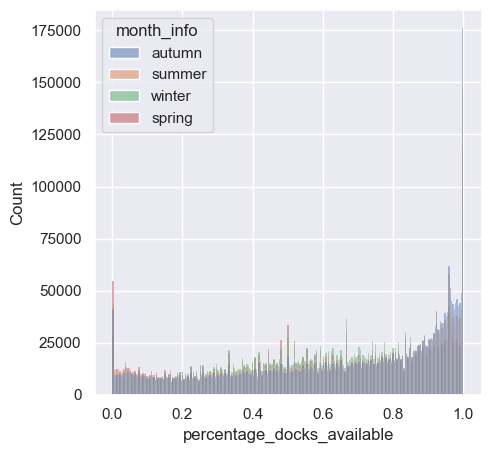

In [26]:
sns.set(rc={'figure.figsize':(5,5)})
sns.histplot(data=df_shifted_copy, x="percentage_docks_available", hue="month_info")

<AxesSubplot:xlabel='hour', ylabel='percentage_docks_available'>

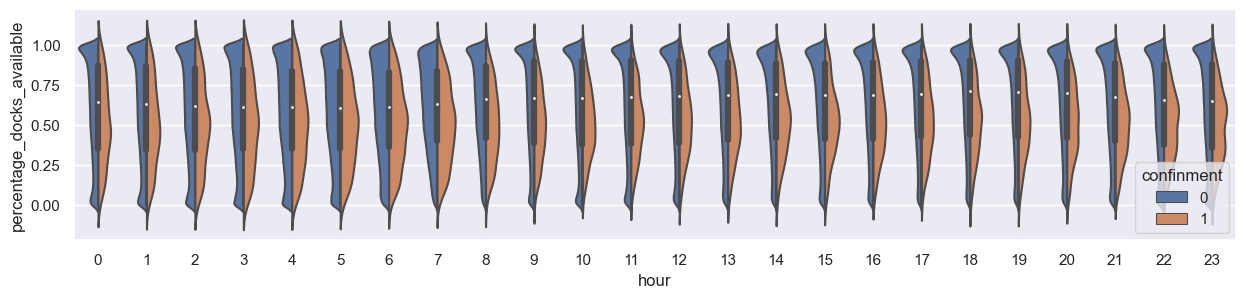

In [20]:
sns.set(rc={'figure.figsize':(15,3)})
sns.violinplot(data=df_shifted_copy, x="hour", y="percentage_docks_available", hue="confinment", split=True)

In [21]:
sns.set(rc={'figure.figsize':(15,3)})
sns.violinplot(data=df_shifted_copy, x="hour", y="percentage_docks_available", hue="day_info", split=True)

<AxesSubplot:xlabel='hour', ylabel='percentage_docks_available'>

In [22]:
sns.set(rc={'figure.figsize':(15,3)})
sns.violinplot(data=df_shifted_copy, x="hour", y="percentage_docks_available", hue="has_holidays", split=True)

<AxesSubplot:xlabel='hour', ylabel='percentage_docks_available'>

In [24]:
sns.set(rc={'figure.figsize':(5,5)})
sns.histplot(data=df_shifted_copy, x="percentage_docks_available", hue="day_info")

<AxesSubplot:xlabel='percentage_docks_available', ylabel='Count'>

<AxesSubplot:xlabel='percentage_docks_available', ylabel='Count'>

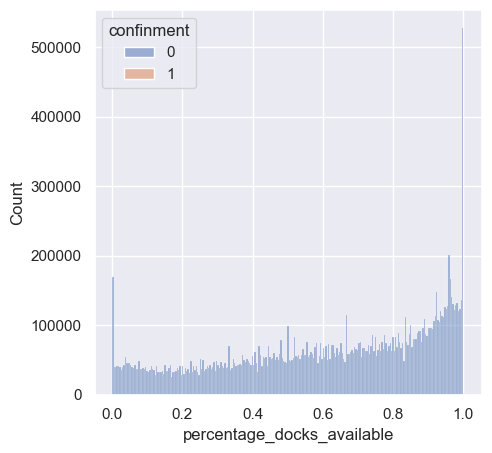

In [25]:
sns.set(rc={'figure.figsize':(5,5)})
sns.histplot(data=df_shifted_copy, x="percentage_docks_available", hue="confinment")

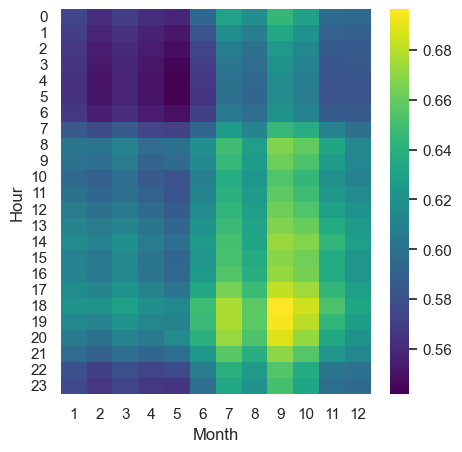

In [42]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

heat_map = pd.pivot_table(df_shifted_copy, values='percentage_docks_available', index=['hour'],columns = ['month'], aggfunc=np.mean)
sns.set(rc={'figure.figsize':(5,5)})
plt.figure()
sns.heatmap(heat_map, annot=False, cmap='viridis') 
            #vmin=0, 
            #vmax=vmax, 
            #cbar_kws={'label': colorbarlabel})
plt.xlabel('Month')
plt.ylabel('Hour')
plt.show()

# Traffic

In [3]:
os.makedirs('./traffic', exist_ok=True)

In [4]:
TRAFFIC_BASE_URL = "https://opendata-ajuntament.barcelona.cat/data/en/dataset/trams"

In [5]:
response = requests.get(TRAFFIC_BASE_URL)

In [8]:
soup = BeautifulSoup(response.content)
resource_items = soup.find_all("li", {"class": "resource-item"})

In [ ]:
for resource_item in resource_items[1:]:
    file_name: str = resource_item.find('a').text[:-4]
    anchor_download_path = resource_item.find('a', href=re.compile(r'^https://opendata-ajuntament.barcelona.cat/data/dataset/*'))
    url_download_path = anchor_download_path['href']
    
    os.system(f"wget '{url_download_path}'")
    os.system(f"mv 'download' './traffic/{file_name}' ")

--2023-07-02 17:37:46--  https://opendata-ajuntament.barcelona.cat/data/dataset/8319c2b1-4c21-4962-9acd-6db4c5ff1148/resource/d3782748-9818-4d3d-a09e-4e8caecb341a/download
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2023_01_Gener_TRAMS_TRAMS.csv [following]
--2023-07-02 17:37:46--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2023_01_Gener_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 106520261 (102M) [text/csv]
Saving to: 'download'

     0K .......... .......... .......... .......... ..........  0% 1.49M 68s
    50K .......... .......... .......... .......... ..........  0% 1.39M 7

In [3]:
df_traffic_2019 = pd.DataFrame()

for csv in tqdm(os.listdir('./traffic/2019/')):
    new_df = pd.read_csv('./traffic/2019/' + csv)
    
    df_traffic_2019 = pd.concat(
        [df_traffic_2019, new_df], 
        axis=0
    )
    
df_traffic_2019.head(5)

100%|███████████████████████████████████████████| 12/12 [00:21<00:00,  1.80s/it]


idTram            data  estatActual  estatPrevist
0       1  20191201000053            1             0
1       2  20191201000053            1             0
2       3  20191201000053            2             0
3       4  20191201000053            2             0
4       5  20191201000053            1             0

In [4]:
df_traffic_2020 = pd.DataFrame()

for csv in tqdm(os.listdir('./traffic/2020/')):
    new_df = pd.read_csv('./traffic/2020/' + csv)
    
    df_traffic_2020 = pd.concat(
        [df_traffic_2020, new_df], 
        axis=0
    )
    
df_traffic_2020.head(5)

100%|███████████████████████████████████████████| 12/12 [00:28<00:00,  2.35s/it]


idTram            data  estatActual  estatPrevist
0       1  20200101000051            0             0
1       2  20200101000051            0             0
2       3  20200101000051            0             0
3       4  20200101000051            0             0
4       5  20200101000051            0             0

In [11]:
df_traffic_2021 = pd.DataFrame()

for csv in tqdm(os.listdir('./traffic/2021/')):
    new_df = pd.read_csv('./traffic/2021/' + csv, encoding='utf-8', errors='ignore')
    
    df_traffic_2021 = pd.concat(
        [df_traffic_2021, new_df], 
        axis=0
    )
    
df_traffic_2021.head(5)

  4%|█▊                                          | 1/24 [00:01<00:30,  1.34s/it]


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 37: invalid start byte

In [12]:
df_traffic_2022 = pd.DataFrame()

for csv in tqdm(os.listdir('./traffic/2022/')):
    new_df = pd.read_csv('./traffic/2022/' + csv)
    
    df_traffic_2022 = pd.concat(
        [df_traffic_2022, new_df], 
        axis=0
    )
    
df_traffic_2022.head(5)

100%|███████████████████████████████████████████| 12/12 [00:31<00:00,  2.64s/it]


idTram            data  estatActual  estatPrevist
0       1  20220101000054            0             0
1       2  20220101000054            0             0
2       3  20220101000054            0             0
3       4  20220101000054            0             0
4       5  20220101000054            0             0

In [13]:
df_traffic_2023 = pd.DataFrame()

for csv in tqdm(os.listdir('./traffic/2023/')):
    new_df = pd.read_csv('./traffic/2023/' + csv)
    
    df_traffic_2023 = pd.concat(
        [df_traffic_2023, new_df], 
        axis=0
    )
    
df_traffic_2023.head(5)

100%|█████████████████████████████████████████████| 7/7 [00:11<00:00,  1.69s/it]


idTram            data  estatActual  estatPrevist
0       1  20230101000054            0             0
1       2  20230101000054            0             0
2       3  20230101000054            0             0
3       4  20230101000054            0             0
4       5  20230101000054            0             0

In [22]:
df_traffic = pd.concat(
        [df_traffic_2019, 
         #df_traffic_2020, 
         df_traffic_2022, 
         df_traffic_2023], 
        axis=0)

In [23]:
df_traffic['date_time'] = pd.to_datetime(df_traffic['data'], format='%Y%m%d%H%M%S')

In [24]:
df_traffic['date'] = pd.to_datetime(df_traffic['date_time']).dt.date


AttributeError: 'Series' object has no attribute 'hour'

In [25]:
df_traffic['hour'] = pd.to_datetime(df_traffic['date_time']).dt.hour

In [26]:
df_traffic = df_traffic.drop(['estatPrevist'], axis=1)

In [28]:
df_traffic = df_traffic.drop(['data'], axis=1)
df_traffic = df_traffic.drop(['date_time'], axis=1)

In [29]:
df_traffic.head()

idTram  estatActual        date  hour
0       1            1  2019-12-01     0
1       2            1  2019-12-01     0
2       3            2  2019-12-01     0
3       4            2  2019-12-01     0
4       5            1  2019-12-01     0

In [30]:
# Checkpoint of the shifted_df
df_traffic.to_csv(
    'df_traffic.csv.gz', 
    index=False, 
    header=True, 
    compression='gzip'
)

In [6]:
import gzip
df_traffic = pd.read_csv('df_traffic.csv.gz', compression='gzip', 
                               header=0, sep=',', quotechar='"')

print(df_traffic.shape)

(124988125, 4)


In [9]:
df_traffic['date_time'] = pd.to_datetime(df_traffic['date'] + ' ' + df_traffic['hour'].astype(str) + ':00')
df_traffic

idTram  estatActual        date  hour           date_time
0               1            1  2019-12-01     0 2019-12-01 00:00:00
1               2            1  2019-12-01     0 2019-12-01 00:00:00
2               3            2  2019-12-01     0 2019-12-01 00:00:00
3               4            2  2019-12-01     0 2019-12-01 00:00:00
4               5            1  2019-12-01     0 2019-12-01 00:00:00
...           ...          ...         ...   ...                 ...
124988036     445            4  2023-07-02    17 2023-07-02 17:00:00
124988051     460            4  2023-07-02    17 2023-07-02 17:00:00
124988077     486            0  2023-07-02    17 2023-07-02 17:00:00
124988082     491            0  2023-07-02    17 2023-07-02 17:00:00
124988105     520            3  2023-07-02    17 2023-07-02 17:00:00

[18254030 rows x 5 columns]

In [10]:
df_traffic['traffic_mean'] = df_traffic.groupby('date_time')['estatActual'].transform('mean')
df_traffic

idTram  estatActual        date  hour           date_time  \
0               1            1  2019-12-01     0 2019-12-01 00:00:00   
1               2            1  2019-12-01     0 2019-12-01 00:00:00   
2               3            2  2019-12-01     0 2019-12-01 00:00:00   
3               4            2  2019-12-01     0 2019-12-01 00:00:00   
4               5            1  2019-12-01     0 2019-12-01 00:00:00   
...           ...          ...         ...   ...                 ...   
124988036     445            4  2023-07-02    17 2023-07-02 17:00:00   
124988051     460            4  2023-07-02    17 2023-07-02 17:00:00   
124988077     486            0  2023-07-02    17 2023-07-02 17:00:00   
124988082     491            0  2023-07-02    17 2023-07-02 17:00:00   
124988105     520            3  2023-07-02    17 2023-07-02 17:00:00   

           traffic_mean  
0              0.923451  
1              0.923451  
2              0.923451  
3              0.923451  
4              0.923451  
...                 ...  
124988036      1.401091  
124988051      1.401091  
124988077      1.401091  
124988082      1.401091  
124988105      1.401091  

[18254030 rows x 6 columns]

In [12]:
df_traffic = df_traffic.drop(['idTram'], axis=1)
df_traffic = df_traffic.drop(['estatActual'], axis=1)

#Remove duplicates
df_traffic = df_traffic.drop_duplicates()
print(df_traffic.shape)

(21803, 4)


In [18]:
df_traffic = df_traffic.drop(['date'], axis=1)
df_traffic = df_traffic.drop(['hour'], axis=1)

In [19]:
df_traffic

date_time  traffic_mean
0         2019-12-01 00:00:00      0.923451
6324      2019-12-01 01:00:00      0.823669
12648     2019-12-01 02:00:00      0.679361
18972     2019-12-01 03:00:00      0.602244
25296     2019-12-01 04:00:00      0.501326
...                       ...           ...
124969505 2023-07-02 13:00:00      1.619735
124974293 2023-07-02 14:00:00      1.441388
124978549 2023-07-02 15:00:00      1.330166
124982805 2023-07-02 16:00:00      1.359897
124985997 2023-07-02 17:00:00      1.401091

[21803 rows x 2 columns]

In [20]:
# Checkpoint of the shifted_df
df_traffic.to_csv(
    'df_traffic.csv.gz', 
    index=False, 
    header=True, 
    compression='gzip'
)

# Reduce dimensions of the shifted dataset and apend traffic

In [15]:

print(df_shifted_copy.shape)

# Define the values to filter
desired_years = [2019, 2022, 2023]
#desired_months = [3, 4]

# Filter the DataFrame based on the desired years
filtered_df = df_shifted_copy[df_shifted_copy['year'].isin(desired_years)]
#filtered_df = df_shifted_copy[df_shifted_copy['month'].isin(desired_months)]

print(filtered_df.shape)

(16368488, 36)
(8387367, 36)


In [24]:
filtered_df['date_time'] = pd.to_datetime(filtered_df['date_time'])
filtered_df.dtypes

station_id                                       int64
num_bikes_available                            float64
num_bikes_available_types.mechanical           float64
num_bikes_available_types.ebike                float64
num_docks_available                            float64
percentage_docks_available                     float64
status                                         float64
lat                                            float64
lon                                            float64
altitude                                       float64
capacity                                       float64
year                                             int64
month                                            int64
day                                              int64
hour                                             int64
date_time                               datetime64[ns]
date                                            object
traffic                                        float64
covid_case

In [26]:
#filtered_df.date = pd.to_datetime(filtered_df.date).dt.date
#df_traffic.date = pd.to_datetime(df_traffic.date).dt.date

#df_final = pd.merge(filtered_df, df_traffic, left_on='date', right_on='hour', how='left')
df_final = pd.merge(filtered_df, df_traffic, on=['date_time'], how='left')
print(filtered_df.shape)
print(df_final.shape)
df_final.head(5)

(8387367, 36)
(8387367, 37)


station_id  num_bikes_available  num_bikes_available_types.mechanical  \
0         532             0.666667                                   0.0   
1         532             1.000000                                   0.0   
2         532             1.000000                                   0.0   
3         532             1.000000                                   0.0   
4         532             1.000000                                   0.0   

   num_bikes_available_types.ebike  num_docks_available  \
0                         0.666667             0.333333   
1                         1.000000             0.000000   
2                         1.000000             0.000000   
3                         1.000000             0.000000   
4                         1.000000             0.000000   

   percentage_docks_available  status        lat       lon  altitude  \
0                    0.333333     1.0  41.395472  2.170939      24.0   
1                    0.000000     1.0  41.395472  2.170939      24.0   
2                    0.000000     1.0  41.395472  2.170939      24.0   
3                    0.000000     1.0  41.395472  2.170939      24.0   
4                    0.000000     1.0  41.395472  2.170939      24.0   

   capacity  year  month  day  hour           date_time        date  traffic  \
0       1.0  2022     11   11    10 2022-11-11 10:00:00  2022-11-11      0.0   
1       1.0  2022     11   11    11 2022-11-11 11:00:00  2022-11-11      0.0   
2       1.0  2022     11   11    12 2022-11-11 12:00:00  2022-11-11      0.0   
3       1.0  2022     11   11    13 2022-11-11 13:00:00  2022-11-11      0.0   
4       1.0  2022     11   11    14 2022-11-11 14:00:00  2022-11-11      0.0   

   covid_cases  confinment  has_holidays  temp  feelslike  humidity  precip  \
0          6.0           0           0.0  17.2       17.2      77.7     0.0   
1          6.0           0           0.0  17.2       17.2      77.7     0.0   
2          6.0           0           0.0  17.2       17.2      77.7     0.0   
3          6.0           0           0.0  17.2       17.2      77.7     0.0   
4          6.0           0           0.0  17.2       17.2      77.7     0.0   

   snow  windspeed  uvindex  visibility day_info hour_info month_info  \
0   0.0       26.6      4.0        15.5  weekday   morning     autumn   
1   0.0       26.6      4.0        15.5  weekday   morning     autumn   
2   0.0       26.6      4.0        15.5  weekday   morning     autumn   
3   0.0       26.6      4.0        15.5  weekday      noon     autumn   
4   0.0       26.6      4.0        15.5  weekday      noon     autumn   

      ctx-4     ctx-3     ctx-2     ctx-1  traffic_mean  
0  0.333333  0.333333  0.333333  0.333333      1.341930  
1  0.000000  0.000000  0.000000  0.333333      2.011086  
2  0.000000  0.000000  0.333333  0.000000      2.081433  
3  0.000000  0.333333  0.000000  0.000000      2.118844  
4  0.333333  0.000000  0.000000  0.000000      2.108018

In [27]:
# Checkpoint of the shifted_df
df_final.to_csv(
    'df_final.csv.gz', 
    index=False, 
    header=True, 
    compression='gzip'
)

### Train / Val / Test Split

In [9]:
#For plotting the variables
selected_columns_df = [
    'station_id', 
    'num_bikes_available', 'num_bikes_available_types.mechanical',                            # docks info
    'num_bikes_available_types.ebike', 'num_docks_available', 'percentage_docks_available',   # docks info
    'status', 'lat', 'lon', 'altitude', 'capacity', 'year',                                          # station info
    'month', 'day', 'hour', 'traffic', 'covid_cases', 'confinment', 'has_holidays',                                     # context info
    'temp', 'feelslike', 'humidity', 'precip', 'snow', 'windspeed', 'uvindex', 'visibility', # meteorological info
    'day_info', 'hour_info', 'month_info', 'ctx-1', 'ctx-2', 'ctx-3', 'ctx-4']


In [28]:
small_selected_columns = ['station_id',
    'percentage_docks_available', 
    'lat', 'lon', 'year',                                          
    'month', 'day', 'hour', 
    'has_holidays',                                     # context info
    'temp', 'precip', 'traffic_mean',
    'day_info', 'hour_info', 'ctx-1', 'ctx-2', 'ctx-3', 'ctx-4']


In [30]:
df_final = df_final[small_selected_columns]

In [31]:
df_final.shape

(8387367, 18)

In [32]:
train_df = df_final[df_final.year != 2023]
test_df = df_final[df_final.year == 2023]

In [33]:
print('Train size: ', train_df.shape)
print('Test size: ', test_df.shape)

Train size:  (7048490, 18)
Test size:  (1338877, 18)


### Exploration

# Cleaning train_df dataset

In [34]:
#Get dummies from categorical values (One-Hot encoder)
def get_dummies(df, column_name):
    type_feature = df[column_name]
    type_dummies = pd.get_dummies(type_feature, prefix=column_name)
    df = pd.concat([df, type_dummies], axis=1).drop(columns=[column_name])
    return df

train_df = get_dummies(train_df, 'day_info')
#train_df = get_dummies(train_df, 'month_info')
train_df = get_dummies(train_df, 'hour_info')

In [35]:
def infinite_values(df):
    count = np.isinf(df).values.sum()
    print("It contains " + str(count) + " infinite values")
    print("printing column name where infinity is present")
    col_name = df.columns.to_series()[np.isinf(df).any()]
    print(col_name)
    df.replace([np.inf, -np.inf], 0, inplace=True)
    count = np.isinf(df).values.sum()
    print("After replacing inifite values, now it contains " + str(count) + " infinite values")
    return df

train_df = infinite_values(train_df)

It contains 0 infinite values
printing column name where infinity is present
Series([], dtype: object)
After replacing inifite values, now it contains 0 infinite values


In [52]:

train_df['traffic_mean'].fillna(0, inplace=True)


traffic_median = train_df[train_df['traffic_mean'] != 0]
traffic_median = traffic_median['traffic_mean']
traffic_median = traffic_median.median()
print(traffic_median)

train_df['traffic_mean'] = np.where(train_df['traffic_mean'] == 0, 
                                    traffic_median, 
                                    train_df['traffic_mean'])


1.3982202447163514


In [38]:
# Converting the int64 columns into float64 columns
#I dont care about the year column because I will remove it later

columns_to_convert = ['month', 'day', 'hour', 'station_id']
train_df[columns_to_convert] = train_df[columns_to_convert].astype(float)
#print(train_df.dtypes)

# Converting the uint columns into float64 columns
columns_uint8 = ['day_info_weekday', 'day_info_weekend', 
                 #'month_info_winter', 'month_info_spring', 
                 #'month_info_summer', 'month_info_autumn',  #These two do not appear in 2023
                'hour_info_early_morning', 'hour_info_eve',
                'hour_info_late_night', 'hour_info_morning',
                'hour_info_night', 'hour_info_noon']
train_df[columns_uint8] = train_df[columns_uint8].astype(float)
print(train_df.dtypes)

station_id                    float64
percentage_docks_available    float64
lat                           float64
lon                           float64
year                            int64
month                         float64
day                           float64
hour                          float64
has_holidays                  float64
temp                          float64
precip                        float64
traffic_mean                  float64
ctx-1                         float64
ctx-2                         float64
ctx-3                         float64
ctx-4                         float64
day_info_weekday              float64
day_info_weekend              float64
hour_info_early_morning       float64
hour_info_eve                 float64
hour_info_late_night          float64
hour_info_morning             float64
hour_info_night               float64
hour_info_noon                float64
dtype: object


In [39]:
#These are the variables I do not need for the prediction:
train_df = train_df.drop(['year'], axis=1)

# Cleaning test_df dataset the same way as train_df

In [40]:
test_df = get_dummies(test_df, 'day_info')
#test_df = get_dummies(test_df, 'month_info')
test_df = get_dummies(test_df, 'hour_info')

In [21]:
test_df = infinite_values(test_df)

It contains 0 infinite values
printing column name where infinity is present
Series([], dtype: object)
After replacing inifite values, now it contains 0 infinite values


In [53]:
test_df['traffic_mean'].fillna(0, inplace=True)


traffic_median = test_df[test_df['traffic_mean'] != 0]
traffic_median = traffic_median['traffic_mean']
traffic_median = traffic_median.median()
print(traffic_median)

test_df['traffic_mean'] = np.where(test_df['traffic_mean'] == 0, 
                                    traffic_median, 
                                    test_df['traffic_mean'])

1.5103373231773667


In [42]:
test_df[columns_to_convert] = test_df[columns_to_convert].astype(float)
test_df[columns_uint8] = test_df[columns_uint8].astype(float)
print(test_df.dtypes)

station_id                    float64
percentage_docks_available    float64
lat                           float64
lon                           float64
year                            int64
month                         float64
day                           float64
hour                          float64
has_holidays                  float64
temp                          float64
precip                        float64
traffic_mean                  float64
ctx-1                         float64
ctx-2                         float64
ctx-3                         float64
ctx-4                         float64
day_info_weekday              float64
day_info_weekend              float64
hour_info_early_morning       float64
hour_info_eve                 float64
hour_info_late_night          float64
hour_info_morning             float64
hour_info_night               float64
hour_info_noon                float64
dtype: object


In [43]:
test_df = test_df.drop(['year'], axis=1)

In [44]:
#Checking that the shape of the two data sets remains the same after the cleaning
print('Train size: ', train_df.shape)
print('Test size: ', test_df.shape)

Train size:  (7048490, 23)
Test size:  (1338877, 23)


### Check point train and test

In [45]:
train_df.to_csv(
    'train_df.csv.gz', 
    index=False, 
    header=True, 
    compression='gzip'
)

In [46]:
test_df.to_csv(
    'test_df.csv.gz', 
    index=False, 
    header=True, 
    compression='gzip'
)

In [3]:
import gzip
train_df = pd.read_csv('train_df.csv.gz', compression='gzip', 
                       header=0, sep=',', quotechar='"')

test_df = pd.read_csv('test_df.csv.gz', compression='gzip', 
                      header=0, sep=',', quotechar='"')

print(train_df.shape)
print(test_df.shape)

(7048490, 22)
(1338877, 22)


# Plotting variables

In [46]:
train_df.head()

station_id  percentage_docks_available        lat       lon  month  \
1400353       157.0                    0.946970  41.413232  2.217765    4.0   
1323652       177.0                    0.958333  41.411075  2.180976    3.0   
667994        335.0                    0.467949  41.393535  2.123123    3.0   
438988        390.0                    0.469091  41.386961  2.182017    3.0   
1645738        99.0                    0.571429  41.380822  2.141539    4.0   

          day  hour  has_holidays  temp  precip     ctx-1     ctx-2     ctx-3  \
1400353   2.0  17.0           1.0  15.0   0.000  0.893939  0.851010  0.792405   
1323652  14.0   6.0           0.0  14.4   0.000  0.958333  0.958333  0.940972   
667994   19.0   2.0           0.0  12.2   1.082  0.408360  0.384615  0.463023   
438988   20.0   1.0           0.0  12.3   1.557  0.423913  0.747253  0.670290   
1645738  26.0   2.0           0.0  15.2   2.752  0.000000  0.000000  0.000000   

            ctx-4  day_info_weekday  day_info_weekend  \
1400353  0.810606               1.0               0.0   
1323652  0.881944               0.0               1.0   
667994   0.538462               0.0               1.0   
438988   0.722222               0.0               1.0   
1645738  0.000000               1.0               0.0   

         hour_info_early_morning  hour_info_eve  hour_info_late_night  \
1400353                      0.0            1.0                   0.0   
1323652                      1.0            0.0                   0.0   
667994                       0.0            0.0                   1.0   
438988                       0.0            0.0                   1.0   
1645738                      0.0            0.0                   1.0   

         hour_info_morning  hour_info_night  hour_info_noon  
1400353                0.0              0.0             0.0  
1323652                0.0              0.0             0.0  
667994                 0.0              0.0             0.0  
438988                 0.0              0.0             0.0  
1645738                0.0              0.0             0.0

<AxesSubplot:xlabel='traffic', ylabel='percentage_docks_available'>

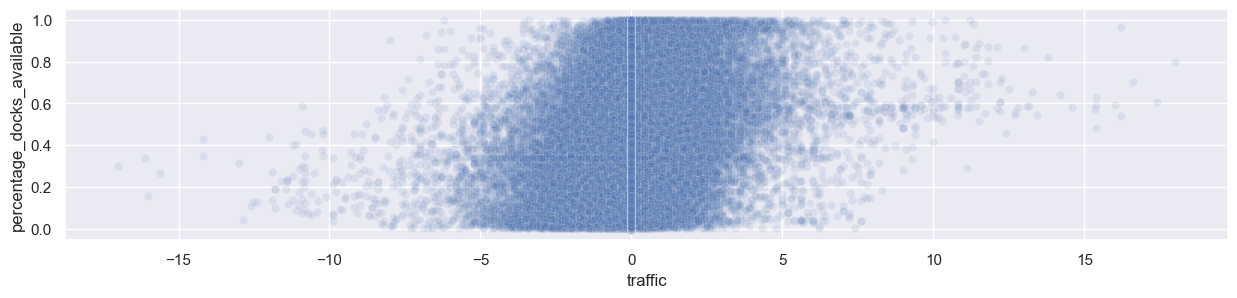

In [69]:
sns.set(rc={'figure.figsize':(15,3)})
sns.scatterplot(data=train_df, x="traffic", y="percentage_docks_available", alpha=0.1)

<AxesSubplot:xlabel='hour', ylabel='traffic_mean'>

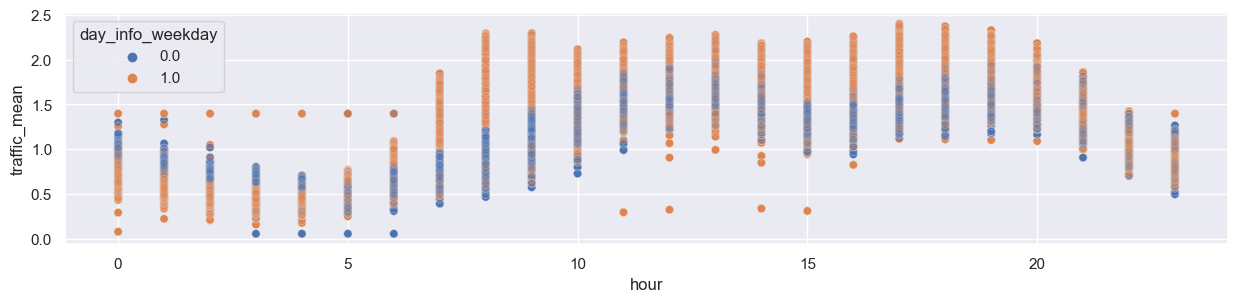

In [54]:
sns.set(rc={'figure.figsize':(15,3)})
sns.scatterplot(data=train_df, x="hour", y="traffic_mean", hue='day_info_weekday', alpha=0.1)

<AxesSubplot:xlabel='traffic_mean', ylabel='percentage_docks_available'>

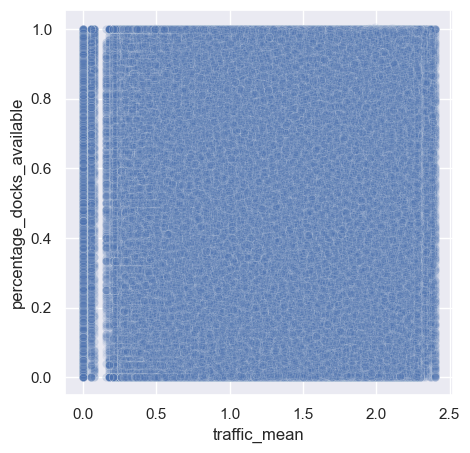

In [49]:
sns.set(rc={'figure.figsize':(5,5)})
sns.scatterplot(data=train_df, x="traffic_mean", y="percentage_docks_available", alpha=0.1)

In [82]:
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

precipitations_2 = pd.pivot_table(train_df, values=['precip', 'percentage_docks_available'], 
                                  index=['day'],columns = ['month'], 
                                  aggfunc={'precip': np.mean, 'percentage_docks_available': np.mean})

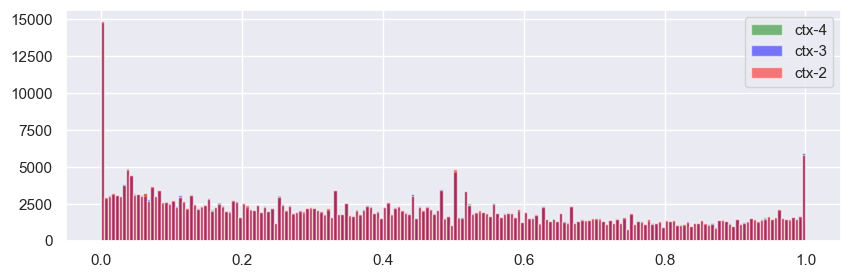

In [53]:
ax = train_df['ctx-4'].hist(bins=200, color='green', alpha=0.5, figsize=(10,3), legend=True)
ax = train_df['ctx-3'].hist(bins=200, color='blue', alpha=0.5, figsize=(10,3), legend=True)
ax = train_df['ctx-2'].hist(bins=200, color='red', alpha=0.5, figsize=(10,3), legend=True)

In [54]:
sns.set(rc={'figure.figsize':(15,3)})
sns.violinplot(data=train_df, x="hour", y="percentage_docks_available", hue="month_info_summer", split=True)


<AxesSubplot:xlabel='hour', ylabel='percentage_docks_available'>

In [50]:
sns.set(rc={'figure.figsize':(15,3)})
sns.violinplot(data=train_df, x="hour", y="percentage_docks_available", hue="confinment", split=True)

<AxesSubplot:xlabel='hour', ylabel='percentage_docks_available'>

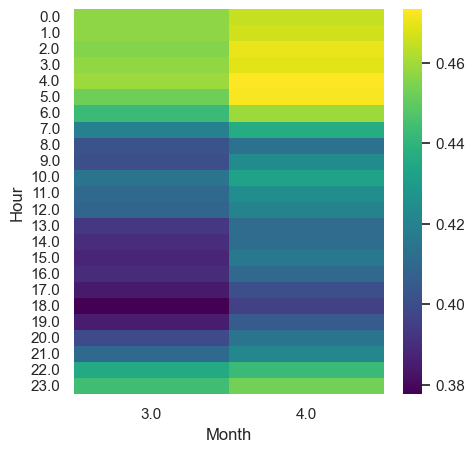

In [48]:
#heatmap
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

heat_map = pd.pivot_table(train_df, values='percentage_docks_available', index=['hour'],columns = ['month'], aggfunc=np.mean)
sns.set(rc={'figure.figsize':(5,5)})
plt.figure()
sns.heatmap(heat_map, annot=False, cmap='viridis') 
            #vmin=0, 
            #vmax=vmax, 
            #cbar_kws={'label': colorbarlabel})
plt.xlabel('Month')
plt.ylabel('Hour')
plt.show()

# Prepare data train and validation, and in X and Y

In [55]:
valid_df = test_df[test_df.month <= 3]
test_df = test_df[test_df.month > 3]

In [56]:
print('Validation size: ', valid_df.shape[0])
print('Test size: ', test_df.shape[0])

Validation size:  1036344
Test size:  302533


### Obtain a small portion of this data, because it is very big

In [57]:
# Randomly sample the DataFrame
train_df = train_df.sample(frac=0.2, random_state=42)
valid_df = valid_df.sample(frac=0.2, random_state=42)
test_df = test_df.sample(frac=0.2, random_state=42)

In [58]:
print('Training size: ', train_df.shape)
print('Validation size: ', valid_df.shape)
print('Test size: ', test_df.shape)

Training size:  (1409698, 23)
Validation size:  (207269, 23)
Test size:  (60507, 23)


In [59]:
#TRAINING:
X_train = train_df.copy()
X_train = X_train.drop(["percentage_docks_available"], axis=1)
y_train = train_df["percentage_docks_available"].copy()
print(X_train.shape, y_train.shape)

#VALIDATION:
X_val = valid_df.copy()
X_val = X_val.drop(["percentage_docks_available"], axis=1)
y_val = valid_df["percentage_docks_available"].copy()
print(X_val.shape, y_val.shape)

#TEST:
X_test = test_df.copy()
X_test = X_test.drop(["percentage_docks_available"], axis=1)
y_test = test_df["percentage_docks_available"].copy()
print(X_test.shape, y_test.shape)

(1409698, 22) (1409698,)
(207269, 22) (207269,)
(60507, 22) (60507,)


In [60]:
# Standard Scaler
from sklearn.preprocessing import StandardScaler

scalerX = StandardScaler().fit(X_train) # Create the transformer StandardScaler and perform the fitting for the training data

X_train_norm = scalerX.transform(X_train)
X_val_norm = scalerX.transform(X_val)
X_test_norm = scalerX.transform(X_test)

#print("\nBefore transformation:")
#print('Train: Max {}, min {}, mean {}, and var {}'.format(np.max(X_train), np.min(X_train), np.mean(X_train), np.var(X_train)))
#print('Validation: Max {}, min {}, mean {}, and var {}'.format(np.max(X_val), np.min(X_val), np.mean(X_val), np.var(X_val)))
#print('Test: Max {}, min {}, mean {}, and var {}'.format(np.max(X_test), np.min(X_test), np.mean(X_test), np.var(X_test)))

#print("\nAfter transformation:")
#print('Train: Max {}, min {}, mean {}, and var {}'.format(np.max(X_train_norm), np.min(X_train_norm), np.mean(X_train_norm), np.var(X_train_norm)))
#print('Validation: Max {}, min {}, mean {}, and var {}'.format(np.max(X_val_norm), np.min(X_val_norm), np.mean(X_val_norm), np.var(X_val_norm)))
#print('Test: Max {}, min {}, mean {}, and var {}'.format(np.max(X_test_norm), np.min(X_test_norm), np.mean(X_test_norm), np.var(X_test_norm)))


### LINEAR REGRESSION

In [61]:
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn import model_selection
from sklearn import neighbors
from sklearn.model_selection import cross_val_score


from sklearn import preprocessing
from sklearn import utils

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error, r2_score

from keras.callbacks import ModelCheckpoint, EarlyStopping

2023-07-02 21:19:25.298544: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [62]:
#Fit with linear_model: Linear Regression

linreg = LinearRegression()
linreg.fit(X_train_norm, y_train)

#print(logreg.coef_, logreg.intercept_)
losspred = linreg.predict(X_val_norm)


print("----- EVALUATION ON TRAIN SET ------")
print("RMSE",mean_squared_error(y_val, losspred, squared=False))  # This is the competition's metric
print("R^2: ",r2_score(y_val, losspred))

# Using this lines of code we can see the predicted price vs the real price
plt.scatter(y_val, losspred, c='C0', alpha=0.3)
plt.axline((0,0),(1,1), c='C1')
plt.xlabel('Percentage of docks available')
plt.ylabel('Predicted % of docks available');
plt.show()


----- EVALUATION ON TRAIN SET ------
RMSE 0.11542408423381538
R^2:  0.8120357542306307


### K-NEIGHBORS REGRESSOR WITH CROSS VALIDATION

In [ ]:

k_values = [i for i in range (2,5)]
knn_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_norm, y_train)
    y_pred = knn.predict(X_val_norm)
    print("----- EVALUATION ON TRAIN SET ------")
    print("RMSE",mean_squared_error(y_val, y_pred, squared=False))  # This is the competition's metric
    print("R^2: ",r2_score(y_val, y_pred))
    

# Using this lines of code we can see the predicted price vs the real price
#plt.scatter(y_val, y_pred, c='C0', alpha=0.3)
#plt.axline((0,0),(1,1), c='C1')
#plt.xlabel('Percentage of docks available')
#plt.ylabel('Predicted percentage of docks available');
#plt.show()


In [14]:
k_values = [101, 301, 501]

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_norm, y_train)
    y_pred = knn.predict(X_val_norm)
    print("----- EVALUATION ON TRAIN SET ------")
    print("RMSE",mean_squared_error(y_val, y_pred, squared=False))  # This is the competition's metric
    print("R^2: ",r2_score(y_val, y_pred))

----- EVALUATION ON TRAIN SET ------
RMSE 18475.05124896204
R^2:  -4399156375.427222


KeyboardInterrupt: 

### DEEP LEARNING, FULLY-CONNECTED NEURAL NETWORK

In [34]:
#! pip install tensorflow
#from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, Adam
from keras import regularizers, optimizers
model = Sequential()

In [35]:
#Set the real number of variables of our final df in input_shape
model.add(Dense(64, input_shape=(None, 21), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, None, 64)          1408      
                                                                 
 dropout_9 (Dropout)         (None, None, 64)          0         
                                                                 
 dense_14 (Dense)            (None, None, 64)          4160      
                                                                 
 dropout_10 (Dropout)        (None, None, 64)          0         
                                                                 
 dense_15 (Dense)            (None, None, 1)           65        
                                                                 
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


In [36]:
adam = optimizers.Adam(learning_rate=0.001, decay=1e-2)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

In [37]:
model.fit(X_train_norm, y_train, epochs=5, batch_size=1024, 
         callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])
_, accuracy = model.evaluate(X_train_norm, y_train, verbose=0)



Epoch 1/5
1377/1377 [==============================] - 7s 5ms/step - loss: 0.0381 - accuracy: 0.0414
Epoch 2/5
1377/1377 [==============================] - 6s 5ms/step - loss: 0.0240 - accuracy: 0.0420
Epoch 3/5
1377/1377 [==============================] - 6s 5ms/step - loss: 0.0217 - accuracy: 0.0420
Epoch 4/5
1377/1377 [==============================] - 6s 5ms/step - loss: 0.0204 - accuracy: 0.0420
Epoch 5/5
1377/1377 [==============================] - 6s 5ms/step - loss: 0.0196 - accuracy: 0.0421


In [ ]:
# make probability predictions with the model
y_pred_FCNN = model.predict(X_val_norm)

### SUBMISSION DATA SET

In [65]:
X_test_metadata = pd.read_csv('metadata_sample_submission.csv')
X_test_metadata

index  station_id  month  day  hour     ctx-4     ctx-3     ctx-2  \
0          0         394      3    7     8  0.753086  0.780864  0.799383   
1          1         337      3   23    12  0.463768  0.536232  0.532609   
2          2         368      3   31     1  0.787037  0.709877  0.611111   
3          3         327      3   23    15  0.753472  0.809028  0.819444   
4          4         328      3    4    20  0.861111  0.802469  0.814815   
...      ...         ...    ...  ...   ...       ...       ...       ...   
54994  54994         269      3   14     3  0.478261  0.478261  0.478261   
54995  54995         280      3    1     5  0.098765  0.074074  0.074074   
54996  54996         180      3   20    16  0.782680  0.821895  0.812092   
54997  54997         277      3   14    11  0.774691  0.953704  0.972222   
54998  54998         425      3   30    16  0.291667  0.277778  0.204861   

          ctx-1  
0      0.824074  
1      0.601449  
2      0.601852  
3      0.736111  
4      0.827160  
...         ...  
54994  0.478261  
54995  0.077160  
54996  0.777778  
54997  0.472222  
54998  0.788194  

[54999 rows x 9 columns]

In [67]:
columns = ['station_id', 'month', 'day', 'hour', 'ctx-4', 'ctx-3',
                     'ctx-2', 'ctx-1']

X_test_metadata[columns] = X_test_metadata[columns].astype(float)
X_test_metadata[columns] = X_test_metadata[columns].astype(float)
print(X_test_metadata.dtypes)

index           int64
station_id    float64
month         float64
day           float64
hour          float64
ctx-4         float64
ctx-3         float64
ctx-2         float64
ctx-1         float64
dtype: object


In [68]:
X_test_metadata = X_test_metadata.drop('index', axis=1)
X_test_metadata

station_id  month   day  hour     ctx-4     ctx-3     ctx-2     ctx-1
0           394.0    3.0   7.0   8.0  0.753086  0.780864  0.799383  0.824074
1           337.0    3.0  23.0  12.0  0.463768  0.536232  0.532609  0.601449
2           368.0    3.0  31.0   1.0  0.787037  0.709877  0.611111  0.601852
3           327.0    3.0  23.0  15.0  0.753472  0.809028  0.819444  0.736111
4           328.0    3.0   4.0  20.0  0.861111  0.802469  0.814815  0.827160
...           ...    ...   ...   ...       ...       ...       ...       ...
54994       269.0    3.0  14.0   3.0  0.478261  0.478261  0.478261  0.478261
54995       280.0    3.0   1.0   5.0  0.098765  0.074074  0.074074  0.077160
54996       180.0    3.0  20.0  16.0  0.782680  0.821895  0.812092  0.777778
54997       277.0    3.0  14.0  11.0  0.774691  0.953704  0.972222  0.472222
54998       425.0    3.0  30.0  16.0  0.291667  0.277778  0.204861  0.788194

[54999 rows x 8 columns]

In [76]:
X_test_metadata = test_df
X_test_metadata = X_test_metadata.sample(n=54999)

In [77]:
X_test_metadata

station_id  percentage_docks_available        lat       lon  month  \
214160        501.0                    0.807292  41.405270  2.142020    4.0   
533725        475.0                    0.762115  41.421674  2.179988    4.0   
590363        470.0                    0.478261  41.443276  2.174624    4.0   
2555337       339.0                    0.365385  41.401708  2.205380    4.0   
7332431        64.0                    0.793651  41.387493  2.169069    4.0   
...             ...                         ...        ...       ...    ...   
6223897       128.0                    0.856031  41.415841  2.195977    4.0   
6420083       117.0                    0.718254  41.390605  2.197231    4.0   
7154667        74.0                    0.905063  41.390009  2.143210    4.0   
3685310       275.0                    0.451613  41.430680  2.182180    4.0   
6312201       123.0                    0.986842  41.398818  2.166735    4.0   

          day  hour  has_holidays  temp  precip  traffic_mean     ctx-1  \
214160   23.0   2.0           0.0  17.9   0.000      0.763285  0.848958   
533725   28.0  15.0           0.0  18.5   0.011      2.196685  0.925110   
590363   15.0  10.0           0.0  14.9   0.000      1.620885  0.496377   
2555337   6.0   1.0           1.0  12.4   0.000      0.697226  0.282051   
7332431  14.0  17.0           0.0  14.4   0.006      2.201638  0.766129   
...       ...   ...           ...   ...     ...           ...       ...   
6223897  24.0  14.0           0.0  16.5   0.350      1.893182  0.903101   
6420083  30.0  21.0           0.0  18.8   3.464      1.424859  0.664000   
7154667  22.0  20.0           0.0  16.4   0.000      1.866898  0.817073   
3685310   4.0   3.0           1.0  11.7   0.000      0.502825  0.451613   
6312201   1.0   4.0           0.0  15.7   0.000      0.610149  0.982063   

            ctx-2     ctx-3     ctx-4  day_info_weekday  day_info_weekend  \
214160   0.817708  0.769634  0.968750               0.0               1.0   
533725   0.995614  0.986842  1.000000               1.0               0.0   
590363   0.492754  0.478261  0.463768               0.0               1.0   
2555337  0.503226  0.483974  0.572347               1.0               0.0   
7332431  0.846774  0.774194  0.623016               1.0               0.0   
...           ...       ...       ...               ...               ...   
6223897  0.990310  0.916505  0.821359               1.0               0.0   
6420083  0.568000  0.587302  0.368889               0.0               1.0   
7154667  0.802395  0.879518  0.955414               0.0               1.0   
3685310  0.451613  0.448925  0.502688               1.0               0.0   
6312201  0.973684  0.960352  0.982456               0.0               1.0   

         hour_info_early_morning  hour_info_eve  hour_info_late_night  \
214160                       0.0            0.0                   1.0   
533725                       0.0            0.0                   0.0   
590363                       0.0            0.0                   0.0   
2555337                      0.0            0.0                   1.0   
7332431                      0.0            1.0                   0.0   
...                          ...            ...                   ...   
6223897                      0.0            0.0                   0.0   
6420083                      0.0            0.0                   0.0   
7154667                      0.0            1.0                   0.0   
3685310                      0.0            0.0                   1.0   
6312201                      0.0            0.0                   1.0   

         hour_info_morning  hour_info_night  hour_info_noon  
214160                 0.0              0.0             0.0  
533725                 0.0              0.0             1.0  
590363                 1.0              0.0             0.0  
2555337                0.0              0.0             0.0  
7332431                0.0              0.0    

In [78]:
X_test_metadata = X_test_metadata.drop('percentage_docks_available', axis=1)

In [79]:
# First, and very important step, we need to preprocess the test data the same way we have done with the train set. 
#X_test = test_set[features].fillna(0)

# Now we can predict the prices for the test set
y_test_pred = linreg.predict(X_test_metadata)

# We generate the submission like this:
df_output = pd.DataFrame(y_test_pred)
df_output = df_output.reset_index()
df_output.columns = ['index','percentage_docks_available']

df_output.to_csv('sample_submission.csv',index=False)
